In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec

import cmocean
import cmocean.cm as cmo
import seaborn as sns


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
df_iron = pd.read_csv('../Dissertation_projects/Data/IRON/Iron.csv', sep=',', index_col=0)

#make all the spots labeled NA a nan value
df_iron = df_iron.replace('NA', np.nan)
df_iron = df_iron.replace('NA ', np.nan)

#make all BDL a 0 
df_iron.loc[df_iron['FeT_uM'] == 'BLD', 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] == 'BLD', 'Fe2_uM'] = 0

# convert columns to numeric data type
df_iron['FeT_uM'] = pd.to_numeric(df_iron['FeT_uM'], errors='coerce')
df_iron['Fe2_uM'] = pd.to_numeric(df_iron['Fe2_uM'], errors='coerce')

df_iron['FeT_uM'] = df_iron['FeT_uM'].where(pd.notna(df_iron['FeT_uM']), other=np.nan)
df_iron['Fe2_uM'] = df_iron['Fe2_uM'].where(pd.notna(df_iron['Fe2_uM']), other=np.nan)

#make all negative a 0 
df_iron.loc[df_iron['FeT_uM'] < 0, 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] < 0, 'Fe2_uM'] = 0

#calculate Fe +3 
df_iron['Fe3_uM'] = df_iron['FeT_uM'] - df_iron['Fe2_uM']
df_iron.loc[df_iron['Fe3_uM'] < 0, 'Fe3_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] > df_iron['FeT_uM'], 'Fe3_uM'] = 0
df_iron['Fe3_uM'] = pd.to_numeric(df_iron['Fe3_uM'], errors='coerce')
df_iron['Fe3_uM'] = df_iron['Fe3_uM'].where(pd.notna(df_iron['Fe3_uM']), other=np.nan)

#time feild 
df_iron['Fe2_Time'] = pd.to_numeric(df_iron['Fe2_Time'], errors='coerce')
df_iron['Fe2_Time'] = df_iron['Fe2_Time'].where(pd.notna(df_iron['Fe2_Time']), other=np.nan)

#time feild 
df_iron['FeT_Time'] = pd.to_numeric(df_iron['FeT_Time'], errors='coerce')
df_iron['FeT_Time'] = df_iron['FeT_Time'].where(pd.notna(df_iron['FeT_Time']), other=np.nan)

df_iron['code'] = df_iron['Location'] + '_' + df_iron['Campaign']

In [3]:
df_doc = pd.read_csv('../Dissertation_projects/Data/TOC/TOC_GOM.csv', sep=',', index_col=0)

#make all BDL a 0 
df_doc.loc[df_doc['NPOC_uM'] == 'BLD', 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] == 'BLD', 'TN_uM'] = 0

df_doc.loc[df_doc['NPOC_uM'] < 0, 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] < 0, 'TN_uM'] = 0

#fix date time 
df_doc['date_time'] = pd.to_datetime(df_doc['Date'])
df_doc['Date'] = df_doc['date_time'].dt.date

df_doc['NPOC_uM'] = pd.to_numeric(df_doc['NPOC_uM'], errors='coerce')
df_doc['NPOC_uM'] = df_doc['NPOC_uM'].where(pd.notna(df_doc['NPOC_uM']), other=np.nan)

df_doc['TN_uM'] = pd.to_numeric(df_doc['TN_uM'], errors='coerce')
df_doc['TN_uM'] = df_doc['TN_uM'].where(pd.notna(df_doc['TN_uM']), other=np.nan)

df_doc['Time'] = pd.to_numeric(df_doc['Time'], errors='coerce')
df_doc['Time'] = df_doc['Time'].where(pd.notna(df_doc['Time']), other=np.nan)

df_doc['code'] = df_doc['Location'] + '_' + df_doc['Campaign']

In [4]:
df_nisk = pd.read_csv('../Dissertation_projects/Data/CTD/NISK_SUMS.csv', sep=',', index_col=0)

# drop rows with NaN index values
df_nisk = df_nisk[df_nisk['Sample_ID'].notna()]
df_nisk['code'] = df_nisk['station'] + '_' + df_nisk['camp']

# reformat the index to be a whole number
df_nisk.index = df_nisk.index.astype(int)

In [5]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

df_meta

,Date,Trip,Station,Lat,Lon,Water_depth,Sample_depth,Sample_depth_units,Wavguide_Path_lengths,BC_time,BC_Chamber_vol_(L),Type,Waveguide_used,Notes,Flagged,Salinity,date_time,code
Sample,,,,,,,,,,,,,,,,,,
214371,2021-10-25,GOM21FA,St.5B,NaN,NaN,NaN,NaN,CM,0.010,NaN,NaN,RHZ,1CM CUV,NaN,NaN,31.846576,2021-10-25,St.5B_GOM21FA
214671,2021-10-27,GOM21FA,St.MK,NaN,NaN,NaN,2,CM,0.010,NaN,NaN,RHZ,1CM CUV,NaN,NaN,31.447235,2021-10-27,St.MK_GOM21FA
214672,2021-10-27,GOM21FA,St.MK,NaN,NaN,NaN,4,CM,0.010,NaN,NaN,RHZ,1CM CUV,NaN,NaN,31.447235,2021-10-27,St.MK_GOM21FA
214673,2021-10-27,GOM21FA,St.MK,NaN,NaN,NaN,6,CM,0.010,NaN,NaN,RHZ,1CM CUV,NaN,NaN,31.447235,2021-10-27,St.MK_GOM21FA
214674,2021-10-27,GOM21FA,St.MK,NaN,NaN,NaN,8,CM,0.010,NaN,NaN,RHZ,1CM CUV,NaN,NaN,31.447235,2021-10-27,St.MK_GOM21FA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225354,2022-07-24,GOM22SU,St.MK,NaN,NaN,NaN,NA,M,0.489,10.166667,0.053721,LANDSYR,LWCC 50 CM #2,BC14,NaN,36.007597,2022-07-24,St.MK_GOM22SU
225355,2022-07-24,GOM22SU,St.MK,NaN,NaN,NaN,NA,M,0.489,10.933333,0.053721,LANDSYR,LWCC 50 CM #2,BC15,NaN,36.007597,2022-07-24,St.MK_GOM22SU
225356,2022-07-24,GOM22SU,St.MK,NaN,NaN,NaN,NA,M,0.489,11.700000,0.053721,LANDSYR,LWCC 50 CM #2,BC16,NaN,36.007597,2022-07-24,St.MK_GOM22SU


In [6]:
df_c = pd.read_csv('../Dissertation_projects/Data/CDOM/Outputs.csv', sep=',', index_col=0)

df_c['Sample_idx'] = df_c.index.astype(object)
df_meta['Sample_idx'] = df_meta.index.astype(object)

df_c.index = df_c['file_id']

df_cdom = df_c.merge(df_meta, on="Sample_idx", how="left")

df_cdom.index = df_cdom['Sample_idx']
df_cdom['Sample'] = df_cdom.index
df_cdom.index = df_cdom['Sample']
df_cdom = df_cdom.drop('Sample_idx', axis = 1)
df_meta = df_meta.drop('Sample_idx', axis = 1)

df_cdom

,ss_275_700_sem,ss_275_295_sem,ss_350_400_sem,R2_275_700_sem,R2_275_295_sem,R2_350_400_sem,SR_sem,ss_275_700_hm,ss_275_295_hm,ss_350_400_hm,...,BC_time,BC_Chamber_vol_(L),Type,Waveguide_used,Notes,Flagged,Salinity,date_time,code,Sample
Sample,,,,,,,,,,,,,,,,,,,,,
211901,0.024250,0.015656,0.026895,0.994926,0.998226,0.964339,0.582120,7.253006,3.453476,-0.001138,...,NaN,NaN,NISK,NaN,NaN,NaN,35.223851,2021-07-15,St.MK_GOM2021,211901
211902,0.023682,0.016434,0.027076,0.993961,0.998077,0.966006,0.606982,7.089678,3.671402,-0.001182,...,NaN,NaN,NISK,NaN,NaN,NaN,35.183855,2021-07-15,St.MK_GOM2021,211902
211902,0.024554,0.021565,0.030541,0.989332,0.993551,0.900661,0.706108,NaN,NaN,NaN,...,NaN,NaN,NISK,NaN,NaN,NaN,35.183855,2021-07-15,St.MK_GOM2021,211902
211903,0.024799,0.011829,0.027034,0.995984,0.998714,0.976966,0.437553,7.419606,2.365078,-0.000872,...,NaN,NaN,NISK,NaN,NaN,NaN,34.505918,2021-07-15,St.MK_GOM2021,211903
211904,0.022008,0.007168,0.021896,0.998638,0.999015,0.992725,0.327371,6.578661,1.036979,7.150482,...,NaN,NaN,NISK,NaN,NaN,NaN,34.486418,2021-07-15,St.MK_GOM2021,211904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225364,0.014319,0.004632,0.010942,0.998577,0.996929,0.993625,0.423367,4.474485,0.324739,3.077208,...,NaN,NaN,RHZ,1CM CUV,NaN,NaN,36.007597,2022-07-23,St.MK_GOM22SU,225364
225364,0.014596,0.004774,0.011522,0.998599,0.996951,0.993927,0.414328,4.562037,0.365645,3.293136,...,NaN,NaN,RHZ,1CM CUV,NaN,NaN,36.007597,2022-07-23,St.MK_GOM22SU,225364
225365,0.017553,0.005233,0.015880,0.996618,0.996428,0.986806,0.329541,5.480805,0.490688,4.915428,...,NaN,NaN,RHZ,1CM CUV,NaN,NaN,36.007597,2022-07-23,St.MK_GOM22SU,225365


In [7]:
#get BC data sets 
df_cdom_bc = df_cdom[df_cdom['Type'] == 'LANDSYR']
df_iron_bc = df_iron[df_iron['Type'] == 'BC']
df_doc_bc = df_doc[df_doc['Type'] == 'BC']

#get PW data sets 
df_cdom_pw = df_cdom[df_cdom['Type'] == 'PW']
df_iron_pw = df_iron[df_iron['Type'] == 'PW']
df_doc_pw = df_doc[df_doc['Type'] == 'PW']

#get WC data sets 
df_cdom_wc = df_cdom[df_cdom['Type'] == 'NISK']
df_iron_wc = df_iron[df_iron['Type'] == 'WC']
df_doc_wc = df_doc[df_doc['Type'] == 'WC']

#get RHZ data 
df_cdom_rz = df_cdom[df_cdom['Type'] == 'RHZ']
df_iron_rz = df_iron[df_iron['Type'].isin(['RZ', 'GBRZ'])]
df_doc_rz = df_doc[df_doc['Type'] == 'RZ']

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_12164\2943100540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cdom_bc['Sample_idx'] = df_cdom_bc.index.astype(object)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_12164\2943100540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_doc_bc['Sample_idx'] = df_doc_bc.index.astype(object)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_12164\2943100540.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

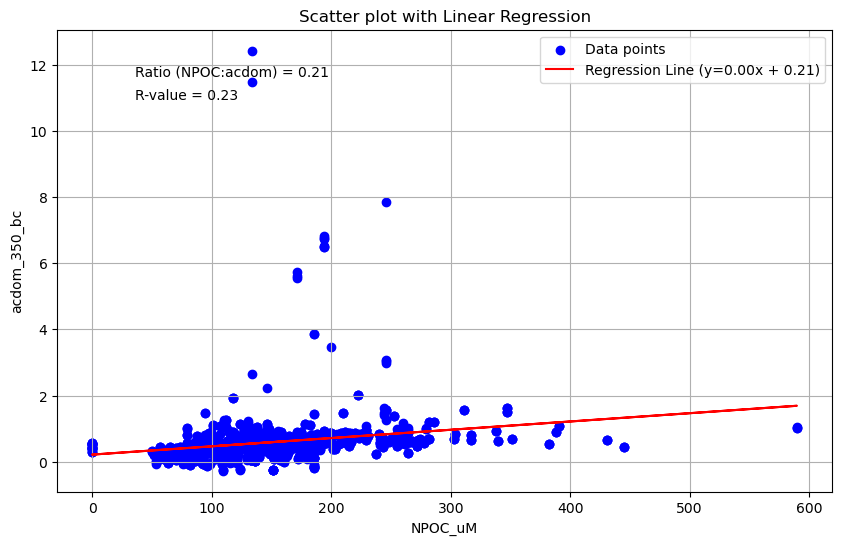

0.21399260105616968

In [8]:
df_cdom_bc['Sample_idx'] = df_cdom_bc.index.astype(object)
df_doc_bc['Sample_idx'] = df_doc_bc.index.astype(object)

df_cdom_bc.index = df_cdom_bc['file_id']

df_cdom_doc = df_cdom_bc.merge(df_doc_bc, on="Sample_idx", how="left")

df_cdom_doc.index = df_cdom_doc['Sample_idx']
df_cdom_doc['Sample'] = df_cdom_doc.index
df_cdom_doc.index = df_cdom_doc['Sample']

df_cdom_bc.index = df_cdom_bc['Sample_idx']
df_cdom_bc['Sample'] = df_cdom_bc.index
df_cdom_bc.index = df_cdom_bc['Sample']

df_doc_bc.index = df_doc_bc['Sample_idx']
df_doc_bc['Sample'] = df_doc_bc.index
df_doc_bc.index = df_doc_bc['Sample']

df_cdom_doc = df_cdom_doc.drop('Sample_idx', axis = 1)
df_doc_bc = df_doc_bc.drop('Sample_idx', axis = 1)
df_cdom_bc = df_cdom_bc.drop('Sample_idx', axis = 1)


# Step 2: Conducting a linear regression
df_cdom_doc = df_cdom_doc.dropna(subset=['NPOC_uM', 'acdom_350_bc'])
slope, intercept, r_value, _, _ = stats.linregress(df_cdom_doc['NPOC_uM'], df_cdom_doc['acdom_350_bc'])

# Step 3: Finding the ratio where NPOC_uM is equal to acdom_350_bc
# slope * x + intercept = x  =>  x * (slope - 1) = -intercept  =>  x = -intercept / (slope - 1)
x_equal = -intercept / (slope - 1)

# Plotting
plt.figure(figsize=(10, 6))
# Step 1: Plotting the scatter plot
plt.scatter(df_cdom_doc['NPOC_uM'], df_cdom_doc['acdom_350_bc'], color='blue', label='Data points')
# Step 4: Plotting the regression line
x_vals = df_cdom_doc['NPOC_uM']
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='red', label=f'Regression Line (y={slope:.2f}x + {intercept:.2f})')

# Step 5: Annotating the plot with the calculated ratio and r-value
plt.annotate(f'Ratio (NPOC:acdom) = {x_equal:.2f}', xy=(0.1, 0.9), xycoords='axes fraction')
plt.annotate(f'R-value = {r_value:.2f}', xy=(0.1, 0.85), xycoords='axes fraction')

plt.xlabel('NPOC_uM')
plt.ylabel('acdom_350_bc')
plt.legend()
plt.title('Scatter plot with Linear Regression')
plt.grid(True)
plt.show()

x_equal

In [9]:
df_hights = pd.read_csv('../Dissertation_projects/Data/Hights.csv', sep=',')

df_hights['code'] = df_hights['Stn'] + '_' + df_hights['Camp']
#df_hights.drop("Stn", axis=1, inplace=True)
#df_hights.drop("Camp", axis=1, inplace=True)
df_hights.index = df_hights['code']
df_hights.drop("code", axis=1, inplace=True)

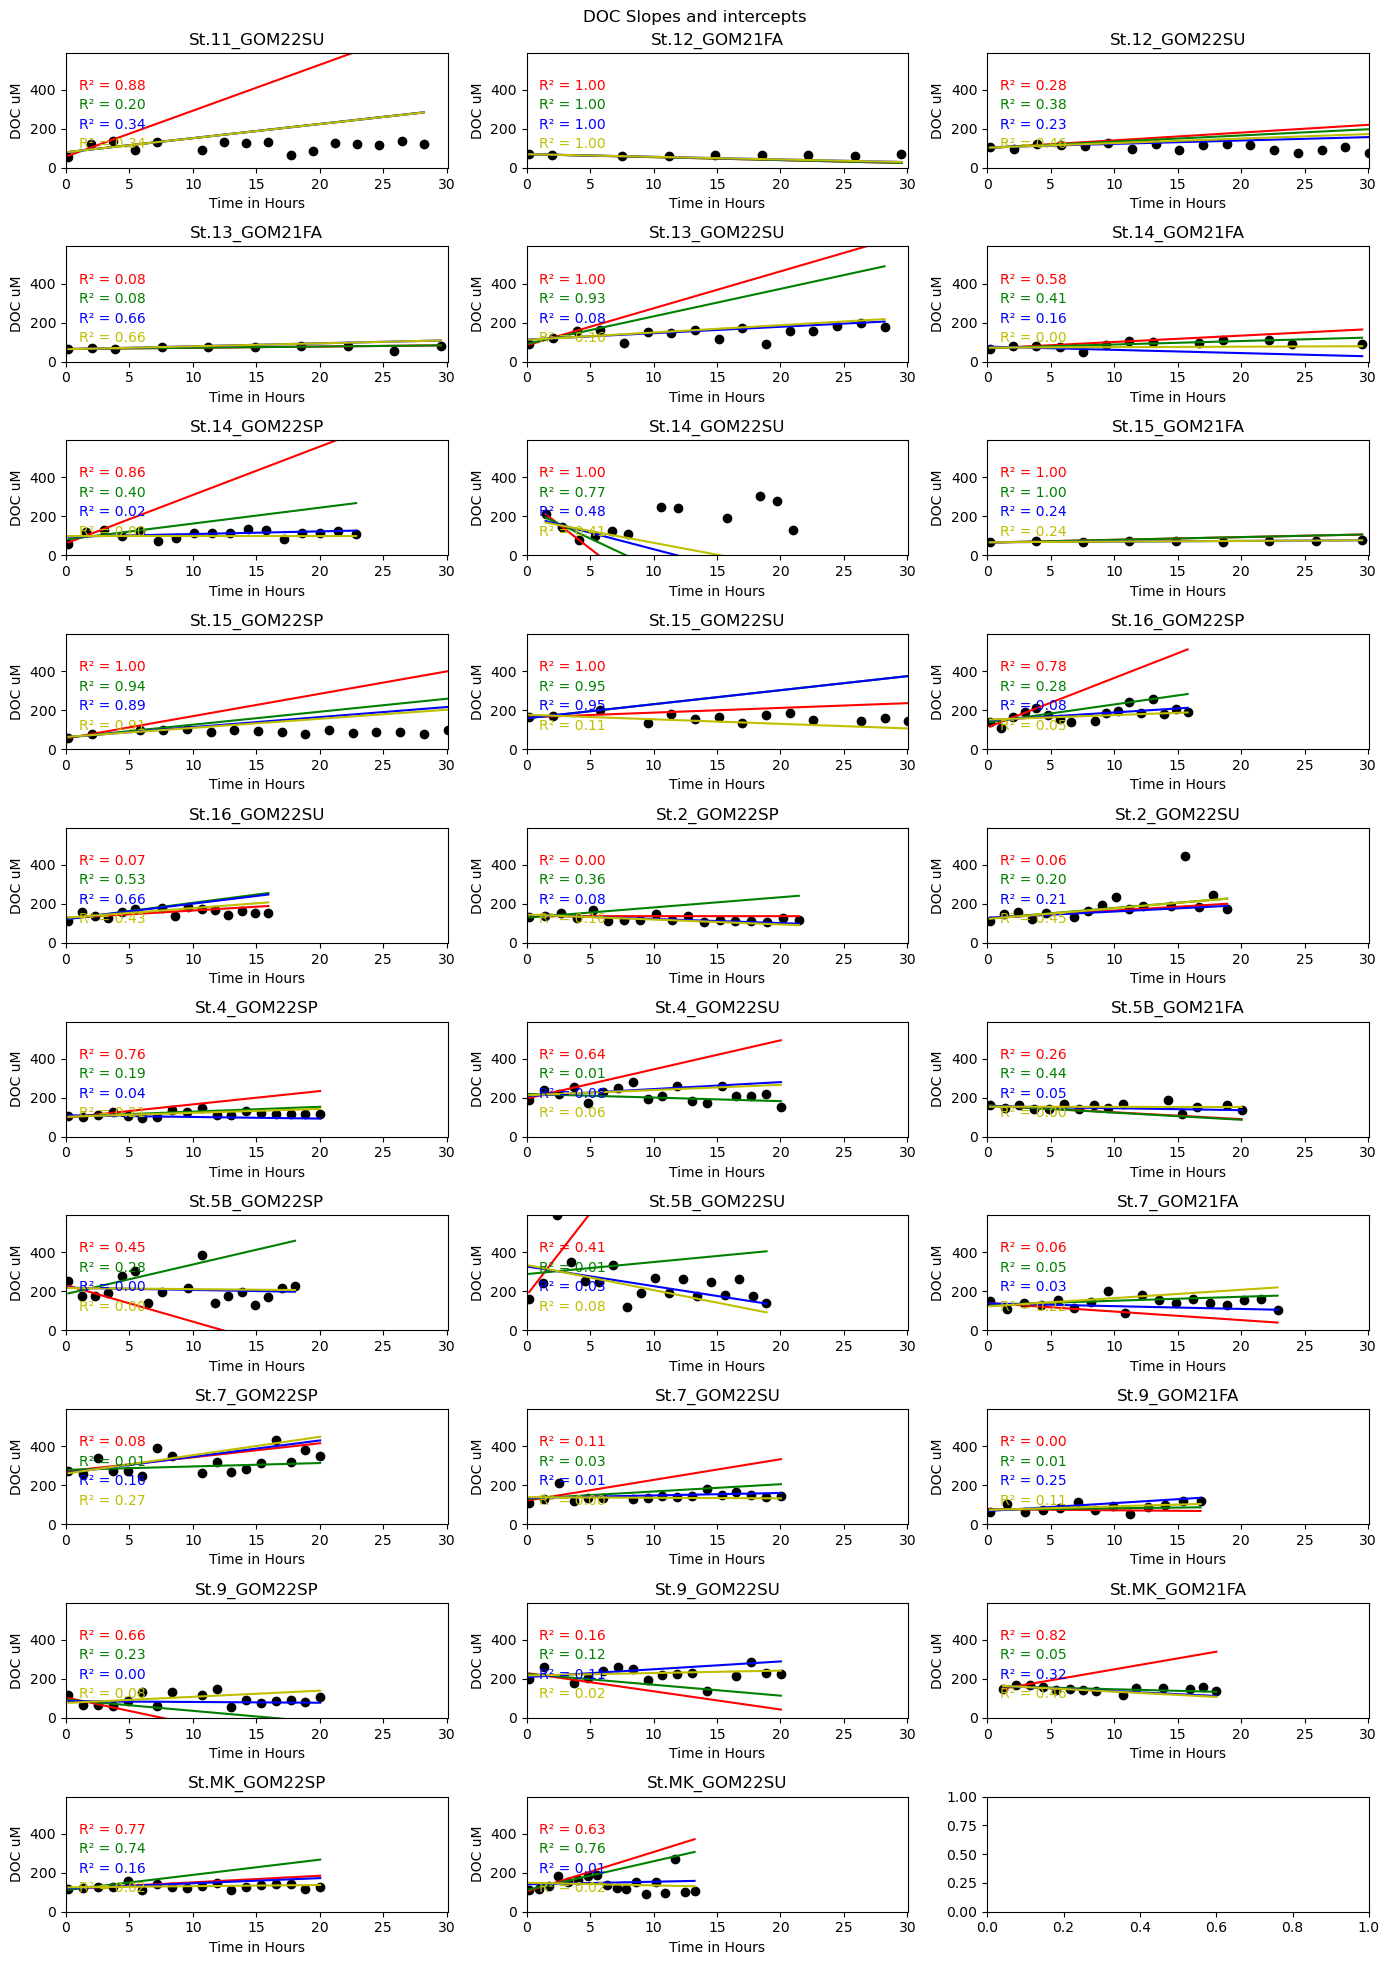

In [10]:
#DOC slopes 
df_doc_bc_plot = df_doc_bc[(df_doc_bc['NPOC_uM'] != 0)]
df_doc_bc_plot = df_doc_bc_plot.dropna(subset=["NPOC_uM"])
codes = df_doc_bc_plot['code'].unique()
df_doc_bc_plot = df_doc_bc_plot[df_doc_bc_plot['code'] != 'St.13_GOM22SP']

#make plot
fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(14, 20)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_doc_bc_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group['Time']
    y = group['NPOC_uM']
    
    xx4 = group.loc[group['Time'] < 4, 'Time'].ravel()
    yy4 = group.loc[group['Time'] < 4, 'NPOC_uM'].ravel()
    
    xx6 = group.loc[group['Time'] < 6, 'Time'].ravel()
    yy6 = group.loc[group['Time'] < 6, 'NPOC_uM'].ravel()
    
    xx8 = group.loc[group['Time'] < 8, 'Time'].ravel()
    yy8 = group.loc[group['Time'] < 8, 'NPOC_uM'].ravel()
    
    xx10 = group.loc[group['Time'] < 10, 'Time'].ravel()
    yy10 = group.loc[group['Time'] < 10, 'NPOC_uM'].ravel()
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c="black")
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time in Hours')
    ax.set_ylabel('DOC uM')
    ax.set_xlim(0,df_doc_bc['Time'].max())
    ax.set_ylim(df_doc_bc['NPOC_uM'].min(),df_doc_bc['NPOC_uM'].max())
    
    # Calculate the slope of the regression line
    slope4, intercept4, r_value4, p_value4, std_err4 = stats.linregress(xx4, yy4)
    slope6, intercept6, r_value6, p_value6, std_err6 = stats.linregress(xx6, yy6)
    slope8, intercept8, r_value8, p_value8, std_err6 = stats.linregress(xx8, yy8)
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(xx10, yy10)

    # Add the regression line to the plot
    ax.plot(x, intercept4 + slope4 * x, c='r')
    ax.plot(x, intercept6 + slope6 * x, c='g')
    ax.plot(x, intercept8 + slope8 * x, c='b')
    ax.plot(x, intercept1 + slope1 * x, c='y')

    
    # Add the equation of the regression line to the plot
    #equation = f'y = {slope:.2f}x + {intercept:.2f}'
    #ax.text(1, 390, equation)
    
    # Add the r-squared value to the plot
    rsquared4 = f'R² = {r_value4**2:.2f}'
    rsquared6 = f'R² = {r_value6**2:.2f}'
    rsquared8 = f'R² = {r_value8**2:.2f}'
    rsquared1 = f'R² = {r_value1**2:.2f}'

    ax.text(1, 400, rsquared4, c='r')
    ax.text(1, 300, rsquared6, c='g')
    ax.text(1, 200, rsquared8, c='b')
    ax.text(1, 100, rsquared1, c='y')
    
    # Add the slope value to the plot
    #sloped = f'Slope = {slope:.3f}'
    #ax.text(1, 270, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'DOC Slopes and intercepts' '\n')
plt.tight_layout()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/DOC_flux.png")

plt.show()


In [11]:
#DOC slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_doc_bc_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    xx4 = group.loc[group['Time'] < 4, 'Time'].ravel()
    yy4 = group.loc[group['Time'] < 4, 'NPOC_uM'].ravel()
    
    xx6 = group.loc[group['Time'] < 6, 'Time'].ravel()
    yy6 = group.loc[group['Time'] < 6, 'NPOC_uM'].ravel()
    
    xx8 = group.loc[group['Time'] < 8, 'Time'].ravel()
    yy8 = group.loc[group['Time'] < 8, 'NPOC_uM'].ravel()
    
    xx10 = group.loc[group['Time'] < 10, 'Time'].ravel()
    yy10 = group.loc[group['Time'] < 10, 'NPOC_uM'].ravel()    
        
    # Calculate the slope of the regression line
    slope4, intercept4, r_value4, p_value4, std_err4 = stats.linregress(xx4, yy4)
    slope6, intercept6, r_value6, p_value6, std_err6 = stats.linregress(xx6, yy6)
    slope8, intercept8, r_value8, p_value8, std_err8 = stats.linregress(xx8, yy8)
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(xx10, yy10)
    
    r_squared_values = {
        'r4': std_err4,
        'r6': std_err6,
        'r8': std_err8,
        'r10':std_err1}

    r_squared_values = {key: value for key, value in r_squared_values.items() if value != 0}
    max_key = min(r_squared_values, key=r_squared_values.get)

    if max_key == 'r4':
        best_slope = slope4
        best_r_squared = r_value4**2
        best_std_err = std_err4
        note_hours = "4 hours"
    elif max_key == 'r6':
        best_slope = slope6
        best_r_squared = r_value6**2
        best_std_err = std_err6
        note_hours = "6 hours"
    elif max_key == 'r8':
        best_slope = slope8
        best_r_squared = r_value8**2
        best_std_err = std_err8 
        note_hours = "8 hours"
    else:
        best_slope = slope1
        best_r_squared = r_value1**2
        best_std_err = std_err1
        note_hours = "10 hours"
    
    # Add the slope value to the plot
    slope = best_slope
    rsquared = best_r_squared
    std_err = best_std_err
    
    dic = {'code':[code],
           'slope_doc':[slope],
           'rsquared_doc':[rsquared], 
           'std_err_doc':[std_err],
           'note_doc': [note_hours]}
    
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_doc = pd.concat(Frames, axis=0, ignore_index=False)
slopes_doc

,slope_doc,rsquared_doc,std_err_doc,note_doc
code,,,,
St.11_GOM22SU,7.231871,0.337235,5.853341,8 hours
St.12_GOM21FA,-1.355944,0.999059,0.041606,8 hours
St.12_GOM22SU,2.307945,0.456216,1.259863,10 hours
St.13_GOM21FA,1.521104,0.658146,0.775180,8 hours
St.13_GOM22SU,18.939732,0.998195,0.805455,4 hours
St.14_GOM21FA,1.777518,0.409972,1.507851,6 hours
St.14_GOM22SP,-0.010024,0.000001,3.911173,10 hours
St.14_GOM22SU,-12.158167,0.409292,7.303104,10 hours
St.15_GOM21FA,0.340341,0.239456,0.606546,8 hours


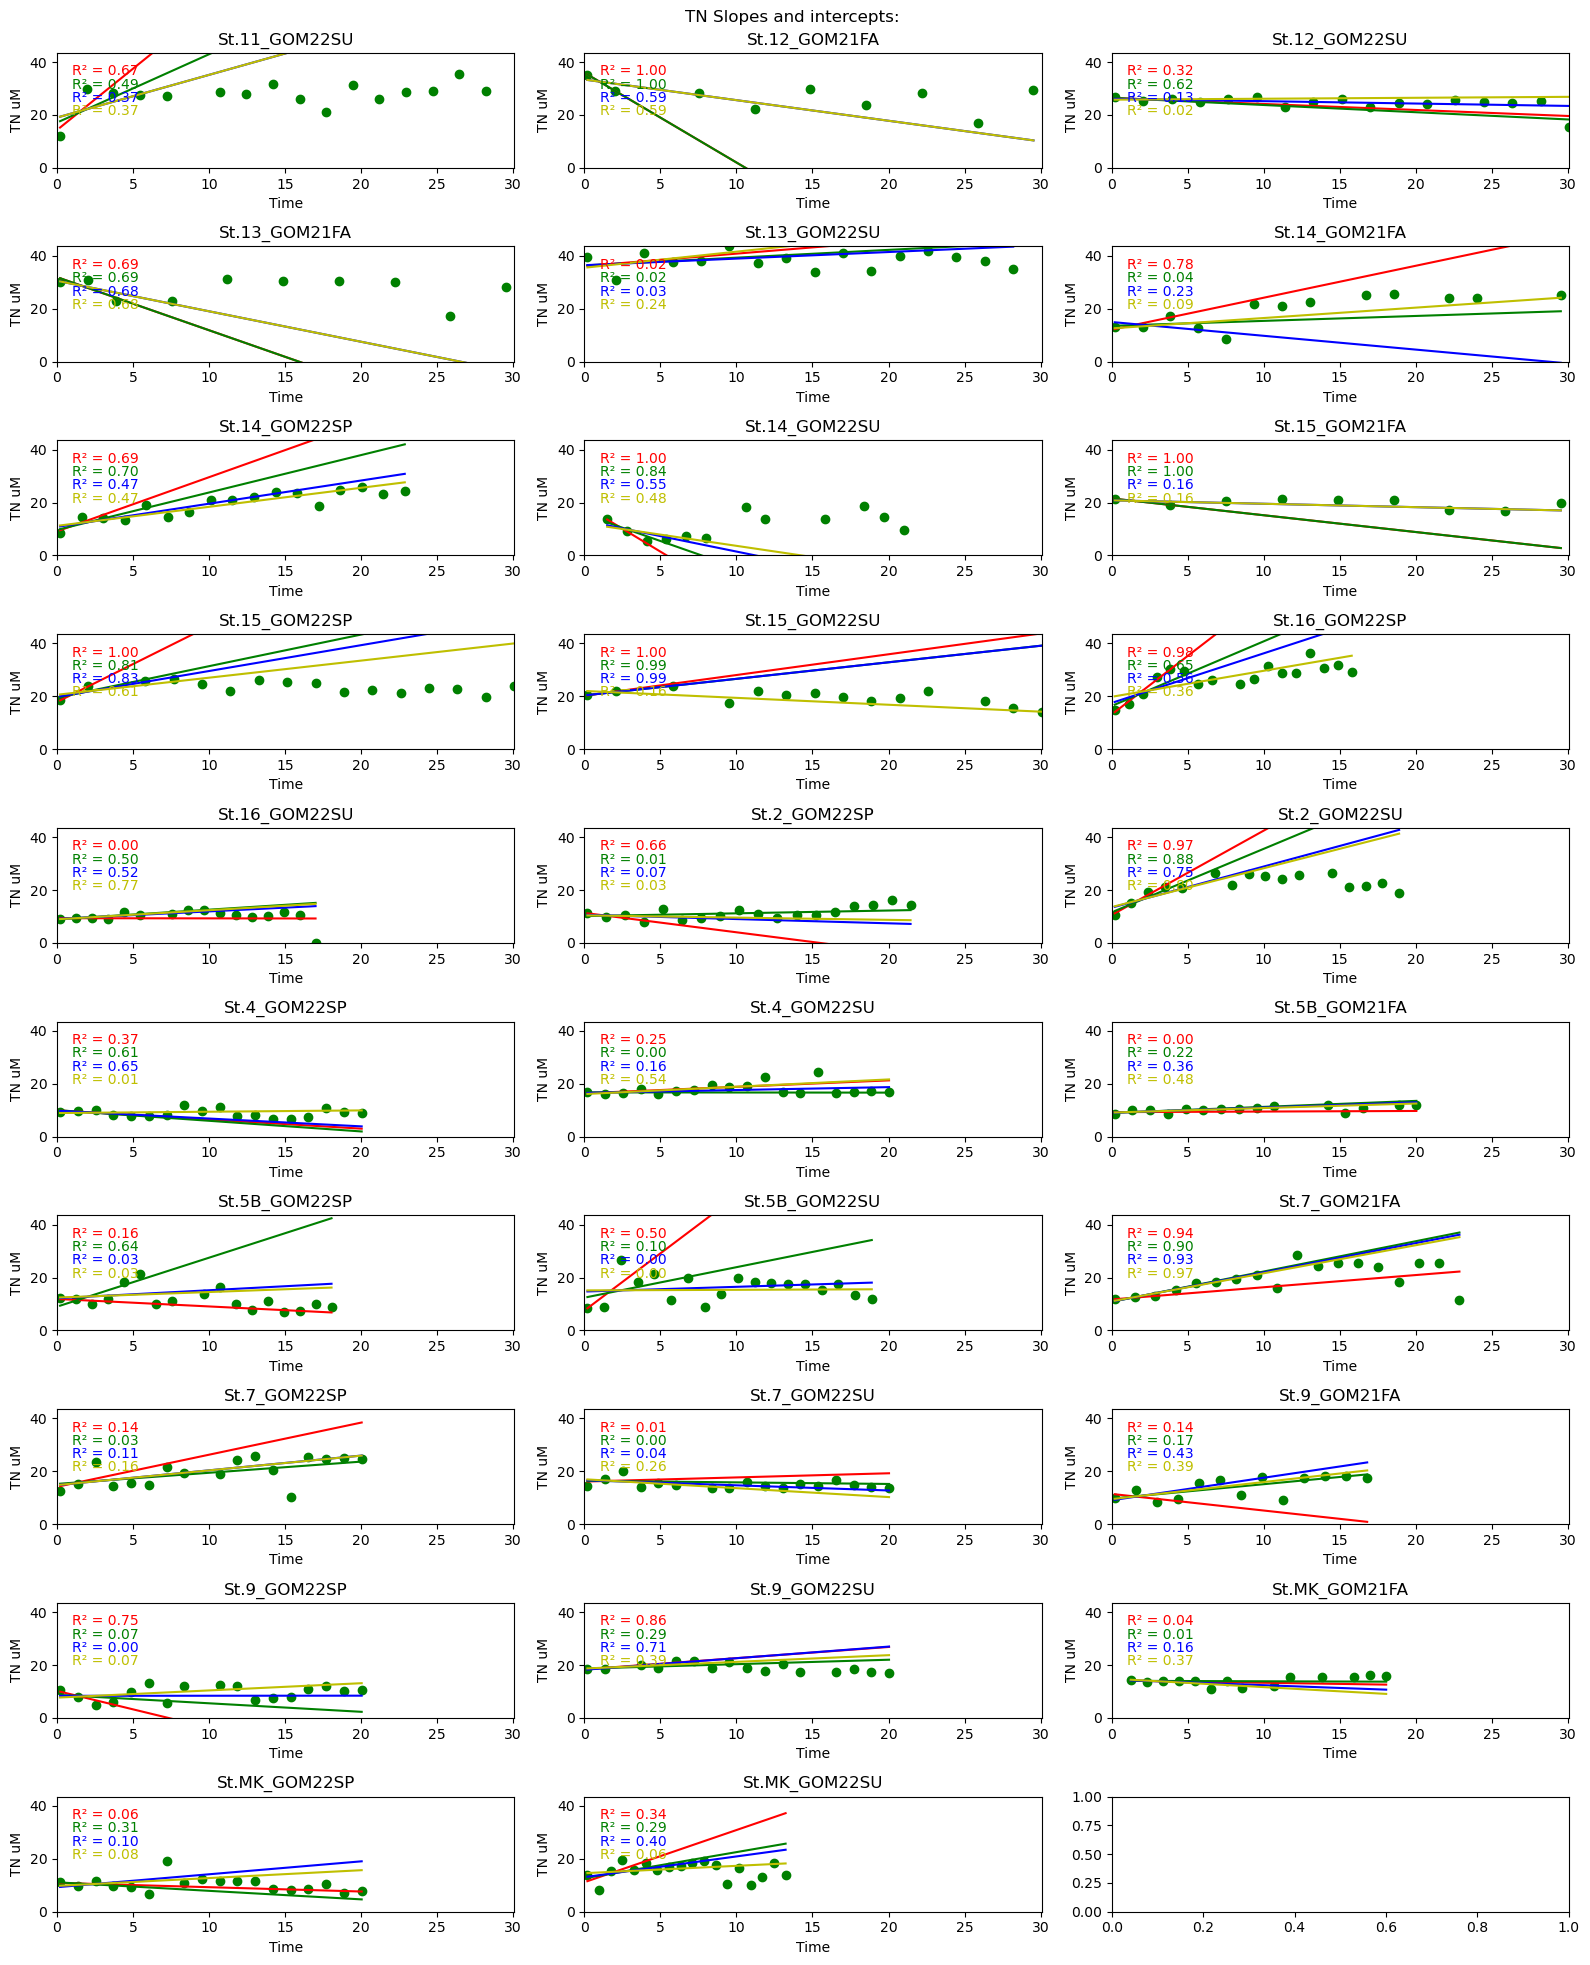

In [12]:
#Nitrogen slopes
fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(16, 20)) 

df_tn_bc_plot = df_doc_bc[(df_doc_bc['TN_uM'] != 0)]
df_tn_bc_plot = df_tn_bc_plot.dropna(subset=["TN_uM"])
codes = df_tn_bc_plot['code'].unique()
df_tn_bc_plot = df_tn_bc_plot[df_tn_bc_plot['code'] != 'St.13_GOM22SP']

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_tn_bc_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group['Time']
    y = group['TN_uM']
    
    xx4 = group.loc[group['Time'] < 4, 'Time'].ravel()
    yy4 = group.loc[group['Time'] < 4, 'TN_uM'].ravel()
    
    xx6 = group.loc[group['Time'] < 6, 'Time'].ravel()
    yy6 = group.loc[group['Time'] < 6, 'TN_uM'].ravel()
    
    xx8 = group.loc[group['Time'] < 8, 'Time'].ravel()
    yy8 = group.loc[group['Time'] < 8, 'TN_uM'].ravel()
    
    xx10 = group.loc[group['Time'] < 10, 'Time'].ravel()
    yy10 = group.loc[group['Time'] < 10, 'TN_uM'].ravel()
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c='green')
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel('TN uM')
    ax.set_xlim(0,df_doc_bc['Time'].max())
    ax.set_ylim(df_doc_bc['TN_uM'].min(),df_doc_bc['TN_uM'].max())
    
    # Calculate the slope of the regression line
    slope4, intercept4, r_value4, p_value4, std_err4 = stats.linregress(xx4, yy4)
    slope6, intercept6, r_value6, p_value6, std_err6 = stats.linregress(xx6, yy6)
    slope8, intercept8, r_value8, p_value8, std_err6 = stats.linregress(xx8, yy8)
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(xx10, yy10)

    # Add the regression line to the plot
    ax.plot(x, intercept4 + slope4 * x, c='r')
    ax.plot(x, intercept6 + slope6 * x, c='g')
    ax.plot(x, intercept8 + slope8 * x, c='b')
    ax.plot(x, intercept1 + slope1 * x, c='y')

    
    # Add the equation of the regression line to the plot
    #equation = f'y = {slope:.2f}x + {intercept:.2f}'
    #ax.text(1, 390, equation)
    
    # Add the r-squared value to the plot
    rsquared4 = f'R² = {r_value4**2:.2f}'
    rsquared6 = f'R² = {r_value6**2:.2f}'
    rsquared8 = f'R² = {r_value8**2:.2f}'
    rsquared1 = f'R² = {r_value1**2:.2f}'

    ax.text(1, 35, rsquared4, c='r')
    ax.text(1, 30, rsquared6, c='g')
    ax.text(1, 25, rsquared8, c='b')
    ax.text(1, 20, rsquared1, c='y')
    
    # Add the slope value to the plot
    #sloped = f'Slope = {slope:.3f}'
    #ax.text(1, 270, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'TN Slopes and intercepts:'+' \n')
plt.tight_layout()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/TN_flux.png")

plt.show()


In [13]:
#TN slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_tn_bc_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    xx4 = group.loc[group['Time'] < 4, 'Time'].ravel()
    yy4 = group.loc[group['Time'] < 4, 'TN_uM'].ravel()
    
    xx6 = group.loc[group['Time'] < 6, 'Time'].ravel()
    yy6 = group.loc[group['Time'] < 6, 'TN_uM'].ravel()
    
    xx8 = group.loc[group['Time'] < 8, 'Time'].ravel()
    yy8 = group.loc[group['Time'] < 8, 'TN_uM'].ravel()
    
    xx10 = group.loc[group['Time'] < 10, 'Time'].ravel()
    yy10 = group.loc[group['Time'] < 10, 'TN_uM'].ravel()    
        
    # Calculate the slope of the regression line
    slope4, intercept4, r_value4, p_value4, std_err4 = stats.linregress(xx4, yy4)
    slope6, intercept6, r_value6, p_value6, std_err6 = stats.linregress(xx6, yy6)
    slope8, intercept8, r_value8, p_value8, std_err8 = stats.linregress(xx8, yy8)
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(xx10, yy10)
    
    r_squared_values = {
        'r4': std_err4,
        'r6': std_err6,
        'r8': std_err8,
        'r10':std_err1}

    r_squared_values = {key: value for key, value in r_squared_values.items() if value != 0}
    max_key = min(r_squared_values, key=r_squared_values.get)

    if max_key == 'r4':
        best_slope = slope4
        best_r_squared = r_value4**2
        best_std_err = std_err4
        note_hours = "4 hours"
    elif max_key == 'r6':
        best_slope = slope6
        best_r_squared = r_value6**2
        best_std_err = std_err6
        note_hours = "6 hours"
    elif max_key == 'r8':
        best_slope = slope8
        best_r_squared = r_value8**2
        best_std_err = std_err8 
        note_hours = "8 hours"
    else:
        best_slope = slope1
        best_r_squared = r_value1**2
        best_std_err = std_err1
        note_hours = "10 hours"
    
    # Add the slope value to the plot
    slope = best_slope
    rsquared = best_r_squared
    std_err = best_std_err
    
    dic = {'code':[code],
           'slope_tn':[slope],
           'rsquared_tn':[rsquared], 
           'std_err_tn':[std_err],
           'note_tn': [note_hours]}
    
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_tn = pd.concat(Frames, axis=0, ignore_index=False)
slopes_tn

,slope_tn,rsquared_tn,std_err_tn,note_tn
code,,,,
St.11_GOM22SU,1.615627,0.370097,1.216912,8 hours
St.12_GOM21FA,-0.779221,0.591800,0.647157,8 hours
St.12_GOM22SU,0.035688,0.023374,0.115343,10 hours
St.13_GOM21FA,-1.152189,0.680754,0.557925,8 hours
St.13_GOM22SU,0.608546,0.237825,0.544706,10 hours
St.14_GOM21FA,-0.521752,0.225986,0.557491,8 hours
St.14_GOM22SP,0.719311,0.470428,0.341309,10 hours
St.14_GOM22SU,-0.849055,0.484177,0.438181,10 hours
St.15_GOM21FA,-0.128571,0.161997,0.292424,8 hours


#CDOM slopes

#df_cdom_bc_plot = df_cdom_bc[df_cdom_bc['code'] != 'St.13_GOM22SP']
#df_cdom_bc_plot = df_cdom_bc_plot[df_cdom_bc_plot['code'] != 'St.14_GOM2021']
#df_cdom_bc_plot = df_cdom_bc_plot.dropna(subset=['acdom_412_bc'])
codes = df_cdom_bc_plot['code'].unique()

fig, axs = plt.subplots(nrows=13, ncols=3, figsize=(16, 25)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_cdom_bc_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group['BC_time']
    y = group['acdom_412_bc']
    
    xx4 = group.loc[group['BC_time'] < 4, 'BC_time'].ravel()
    yy4 = group.loc[group['BC_time'] < 4, 'acdom_412_bc'].ravel()
    
    xx6 = group.loc[group['BC_time'] < 6, 'BC_time'].ravel()
    yy6 = group.loc[group['BC_time'] < 6, 'acdom_412_bc'].ravel()
    
    xx8 = group.loc[group['BC_time'] < 8, 'BC_time'].ravel()
    yy8 = group.loc[group['BC_time'] < 8, 'acdom_412_bc'].ravel()
    
    xx10 = group.loc[group['BC_time'] < 10, 'BC_time'].ravel()
    yy10 = group.loc[group['BC_time'] < 10, 'acdom_412_bc'].ravel()
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c='y')
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel('aCDOM 412')
    ax.set_xlim(0,df_doc_bc['Time'].max())
    ax.set_ylim(-1,2)
    
    # Calculate the slope of the regression line
    slope4, intercept4, r_value4, p_value4, std_err4 = stats.linregress(xx4, yy4)
    slope6, intercept6, r_value6, p_value6, std_err6 = stats.linregress(xx6, yy6)
    slope8, intercept8, r_value8, p_value8, std_err6 = stats.linregress(xx8, yy8)
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(xx10, yy10)

    # Add the regression line to the plot
    ax.plot(x, intercept4 + slope4 * x, c='r')
    ax.plot(x, intercept6 + slope6 * x, c='g')
    ax.plot(x, intercept8 + slope8 * x, c='b')
    ax.plot(x, intercept1 + slope1 * x, c='y')
    
    # Add the equation of the regression line to the plot
    #equation = f'y = {slope:.2f}x + {intercept:.2f}'
    #ax.text(1, 390, equation)
    
    # Add the r-squared value to the plot
    rsquared4 = f'R² = {r_value4**2:.2f}'
    rsquared6 = f'R² = {r_value6**2:.2f}'
    rsquared8 = f'R² = {r_value8**2:.2f}'
    rsquared1 = f'R² = {r_value1**2:.2f}'

    ax.text(1, 2.2, rsquared4, c='r')
    ax.text(1, 1.8, rsquared6, c='g')
    ax.text(1, 1.4, rsquared8, c='b')
    ax.text(1, 1, rsquared1, c='y')

# Add overall figure labels and color bar
fig.suptitle(r'$a_{\mathrm{CDOM}}$ (m$^{-1}$) 412 nm'+'\n')
plt.tight_layout()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/CDOM412_flux.png")

plt.show()


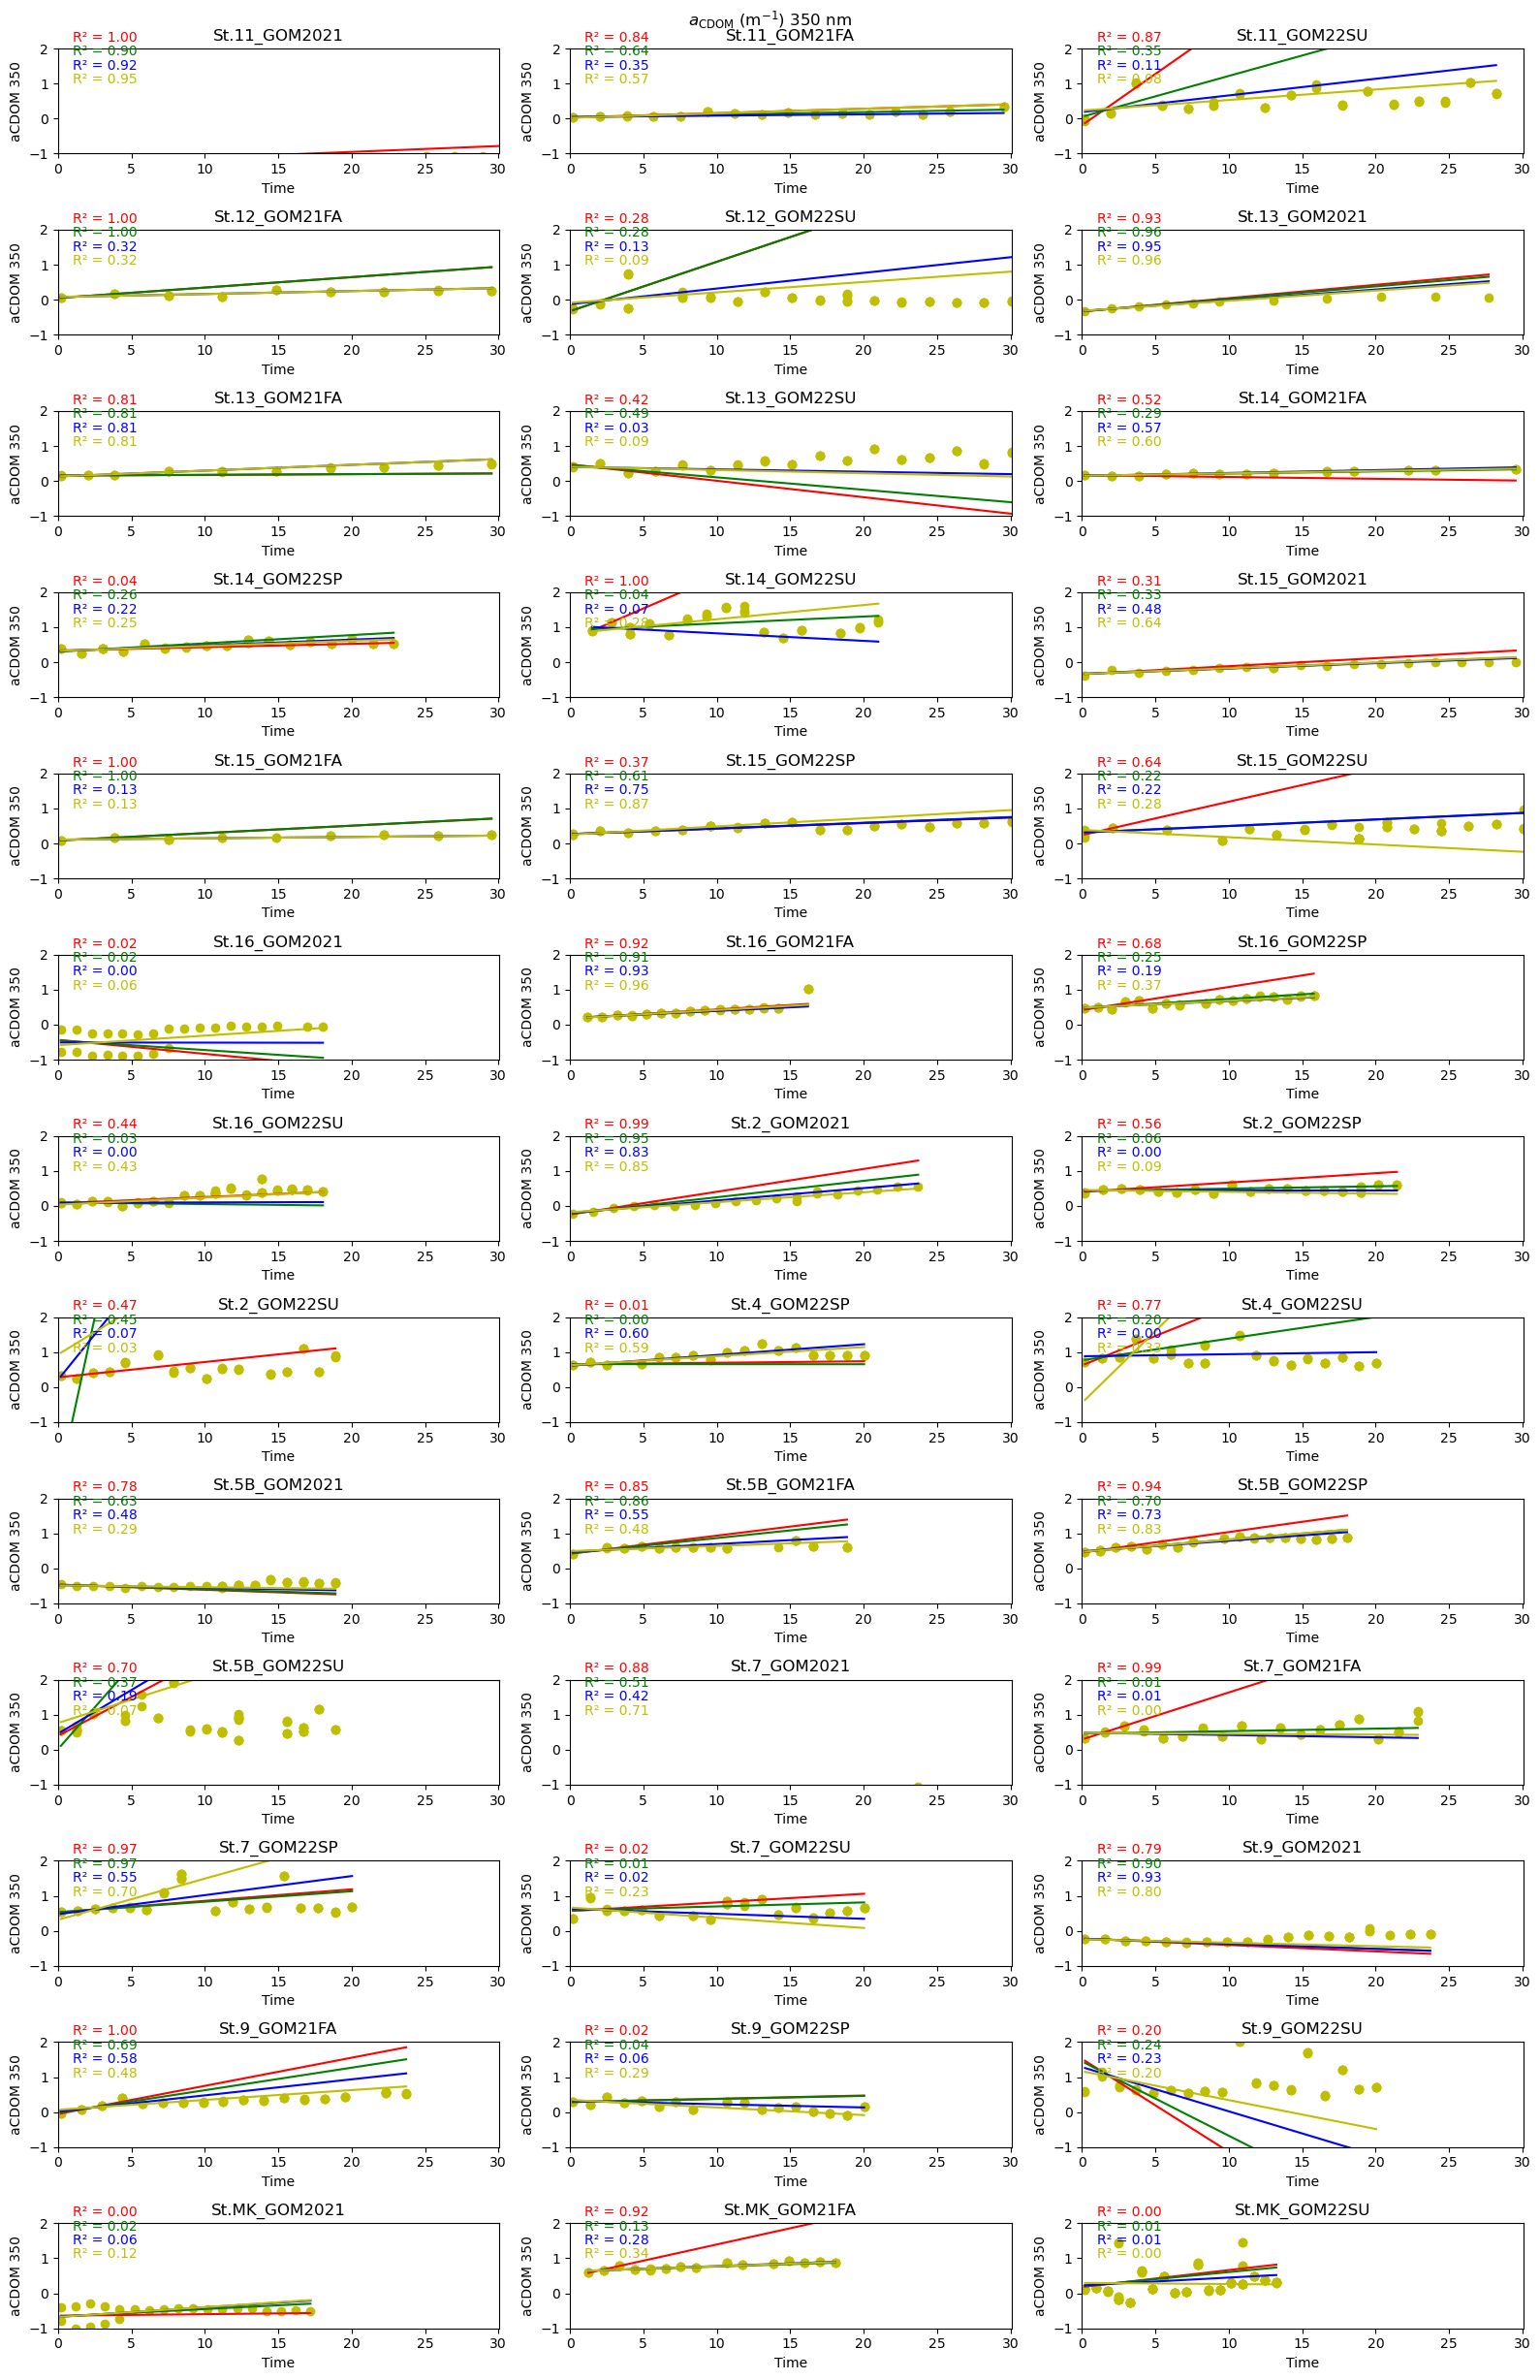

In [14]:
#CDOM slopes
df_cdom_bc_plot = df_cdom_bc[df_cdom_bc['code'] != 'St.13_GOM22SP']
df_cdom_bc_plot = df_cdom_bc_plot[df_cdom_bc_plot['code'] != 'St.14_GOM2021']
df_cdom_bc_plot = df_cdom_bc_plot.dropna(subset=['acdom_350_bc'])
codes = df_cdom_bc_plot['code'].unique()

fig, axs = plt.subplots(nrows=13, ncols=3, figsize=(16, 25)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_cdom_bc_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group['BC_time']
    y = group['acdom_350_bc']
    
    xx4 = group.loc[group['BC_time'] < 4, 'BC_time'].ravel()
    yy4 = group.loc[group['BC_time'] < 4, 'acdom_350_bc'].ravel()
    
    xx6 = group.loc[group['BC_time'] < 6, 'BC_time'].ravel()
    yy6 = group.loc[group['BC_time'] < 6, 'acdom_350_bc'].ravel()
    
    xx8 = group.loc[group['BC_time'] < 8, 'BC_time'].ravel()
    yy8 = group.loc[group['BC_time'] < 8, 'acdom_350_bc'].ravel()
    
    xx10 = group.loc[group['BC_time'] < 10, 'BC_time'].ravel()
    yy10 = group.loc[group['BC_time'] < 10, 'acdom_350_bc'].ravel()
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c='y')
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel('aCDOM 350')
    ax.set_xlim(0,df_doc_bc['Time'].max())
    ax.set_ylim(-1,2)
    
    # Calculate the slope of the regression line
    slope4, intercept4, r_value4, p_value4, std_err4 = stats.linregress(xx4, yy4)
    slope6, intercept6, r_value6, p_value6, std_err6 = stats.linregress(xx6, yy6)
    slope8, intercept8, r_value8, p_value8, std_err6 = stats.linregress(xx8, yy8)
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(xx10, yy10)

    # Add the regression line to the plot
    ax.plot(x, intercept4 + slope4 * x, c='r')
    ax.plot(x, intercept6 + slope6 * x, c='g')
    ax.plot(x, intercept8 + slope8 * x, c='b')
    ax.plot(x, intercept1 + slope1 * x, c='y')
    
    # Add the equation of the regression line to the plot
    #equation = f'y = {slope:.2f}x + {intercept:.2f}'
    #ax.text(1, 390, equation)
    
    # Add the r-squared value to the plot
    rsquared4 = f'R² = {r_value4**2:.2f}'
    rsquared6 = f'R² = {r_value6**2:.2f}'
    rsquared8 = f'R² = {r_value8**2:.2f}'
    rsquared1 = f'R² = {r_value1**2:.2f}'

    ax.text(1, 2.2, rsquared4, c='r')
    ax.text(1, 1.8, rsquared6, c='g')
    ax.text(1, 1.4, rsquared8, c='b')
    ax.text(1, 1, rsquared1, c='y')

# Add overall figure labels and color bar
fig.suptitle(r'$a_{\mathrm{CDOM}}$ (m$^{-1}$) 350 nm'+'\n')
plt.tight_layout()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/CDOM350_flux.png")

plt.show()


#cdom slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_cdom_bc_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    xx4 = group.loc[group['BC_time'] < 4, 'BC_time'].ravel()
    yy4 = group.loc[group['BC_time'] < 4, 'acdom_412_bc'].ravel()
    
    xx6 = group.loc[group['BC_time'] < 6, 'BC_time'].ravel()
    yy6 = group.loc[group['BC_time'] < 6, 'acdom_412_bc'].ravel()
    
    xx8 = group.loc[group['BC_time'] < 8, 'BC_time'].ravel()
    yy8 = group.loc[group['BC_time'] < 8, 'acdom_412_bc'].ravel()
    
    xx10 = group.loc[group['BC_time'] < 10, 'BC_time'].ravel()
    yy10 = group.loc[group['BC_time'] < 10, 'acdom_412_bc'].ravel()    
        
    # Calculate the slope of the regression line
    slope4, intercept4, r_value4, p_value4, std_err4 = stats.linregress(xx4, yy4)
    slope6, intercept6, r_value6, p_value6, std_err6 = stats.linregress(xx6, yy6)
    slope8, intercept8, r_value8, p_value8, std_err8 = stats.linregress(xx8, yy8)
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(xx10, yy10)
    
    r_squared_values = {
        'r4': std_err4,
        'r6': std_err6,
        'r8': std_err8,
        'r10':std_err1}

    r_squared_values = {key: value for key, value in r_squared_values.items() if value != 0}
    max_key = min(r_squared_values, key=r_squared_values.get)

    if max_key == 'r4':
        best_slope = slope4
        best_r_squared = r_value4**2
        best_std_err = std_err4
        note_hours = "4 hours"
    elif max_key == 'r6':
        best_slope = slope6
        best_r_squared = r_value6**2
        best_std_err = std_err6
        note_hours = "6 hours"
    elif max_key == 'r8':
        best_slope = slope8
        best_r_squared = r_value8**2
        best_std_err = std_err8 
        note_hours = "8 hours"
    else:
        best_slope = slope1
        best_r_squared = r_value1**2
        best_std_err = std_err1
        note_hours = "10 hours"
    
    # Add the slope value to the plot
    slope = best_slope
    rsquared = best_r_squared
    std_err = best_std_err
    
    dic = {'code':[code],
           'slope_a412':[slope],
           'rsquared_a412':[rsquared], 
           'std_err_a412':[std_err],
           'note_a412': [note_hours]}
    
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_a412 = pd.concat(Frames, axis=0, ignore_index=False)
slopes_a412

In [15]:
#cdom slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_cdom_bc_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    xx4 = group.loc[group['BC_time'] < 4, 'BC_time'].ravel()
    yy4 = group.loc[group['BC_time'] < 4, 'acdom_350_bc']*x_equal.ravel()
    
    xx6 = group.loc[group['BC_time'] < 6, 'BC_time'].ravel()
    yy6 = group.loc[group['BC_time'] < 6, 'acdom_350_bc']*x_equal.ravel()
    
    xx8 = group.loc[group['BC_time'] < 8, 'BC_time'].ravel()
    yy8 = group.loc[group['BC_time'] < 8, 'acdom_350_bc']*x_equal.ravel()
    
    xx10 = group.loc[group['BC_time'] < 10, 'BC_time'].ravel()
    yy10 = group.loc[group['BC_time'] < 10, 'acdom_350_bc']*x_equal.ravel()    
        
    # Calculate the slope of the regression line
    slope4, intercept4, r_value4, p_value4, std_err4 = stats.linregress(xx4, yy4)
    slope6, intercept6, r_value6, p_value6, std_err6 = stats.linregress(xx6, yy6)
    slope8, intercept8, r_value8, p_value8, std_err8 = stats.linregress(xx8, yy8)
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(xx10, yy10)
    
    r_squared_values = {
        'r4': std_err4,
        'r6': std_err6,
        'r8': std_err8,
        'r10':std_err1}

    r_squared_values = {key: value for key, value in r_squared_values.items() if value != 0}
    max_key = min(r_squared_values, key=r_squared_values.get)

    if max_key == 'r4':
        best_slope = slope4
        best_r_squared = r_value4**2
        best_std_err = std_err4
        note_hours = "4 hours"
    elif max_key == 'r6':
        best_slope = slope6
        best_r_squared = r_value6**2
        best_std_err = std_err6
        note_hours = "6 hours"
    elif max_key == 'r8':
        best_slope = slope8
        best_r_squared = r_value8**2
        best_std_err = std_err8 
        note_hours = "8 hours"
    else:
        best_slope = slope1
        best_r_squared = r_value1**2
        best_std_err = std_err1
        note_hours = "10 hours"
    
    # Add the slope value to the plot
    slope = best_slope
    rsquared = best_r_squared
    std_err = best_std_err
    
    dic = {'code':[code],
           'slope_a350':[slope],
           'rsquared_a350':[rsquared], 
           'std_err_a350':[std_err],
           'note_a350': [note_hours]}
    
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_a350 = pd.concat(Frames, axis=0, ignore_index=False)
slopes_a350

,slope_a350,rsquared_a350,std_err_a350,note_a350
code,,,,
St.11_GOM2021,0.001748,0.952583,0.000195,10 hours
St.11_GOM21FA,0.000826,0.353014,0.000310,8 hours
St.11_GOM22SU,0.006425,0.078658,0.005498,10 hours
St.12_GOM21FA,0.006385,0.996677,0.000184,4 hours
St.12_GOM22SU,0.006332,0.086691,0.004715,10 hours
St.13_GOM2021,0.006183,0.962438,0.000611,10 hours
St.13_GOM21FA,0.000440,0.807854,0.000081,4 hours
St.13_GOM22SU,-0.001986,0.091764,0.001562,10 hours
St.14_GOM21FA,0.001482,0.598999,0.000303,10 hours


In [16]:
#clean out the Iron data for the slopes 
df_iron_bc_fe2_cl = df_iron_bc.drop(df_iron_bc[(df_iron_bc['Fe2_uM'] == 0) | (df_iron_bc['Fe2_uM'].isna())].index)

#clean out the Iron data for the slopes 
df_iron_bc_fe3_cl = df_iron_bc.drop(df_iron_bc[(df_iron_bc['Fe3_uM'] == 0) | (df_iron_bc['Fe3_uM'].isna())].index)

C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


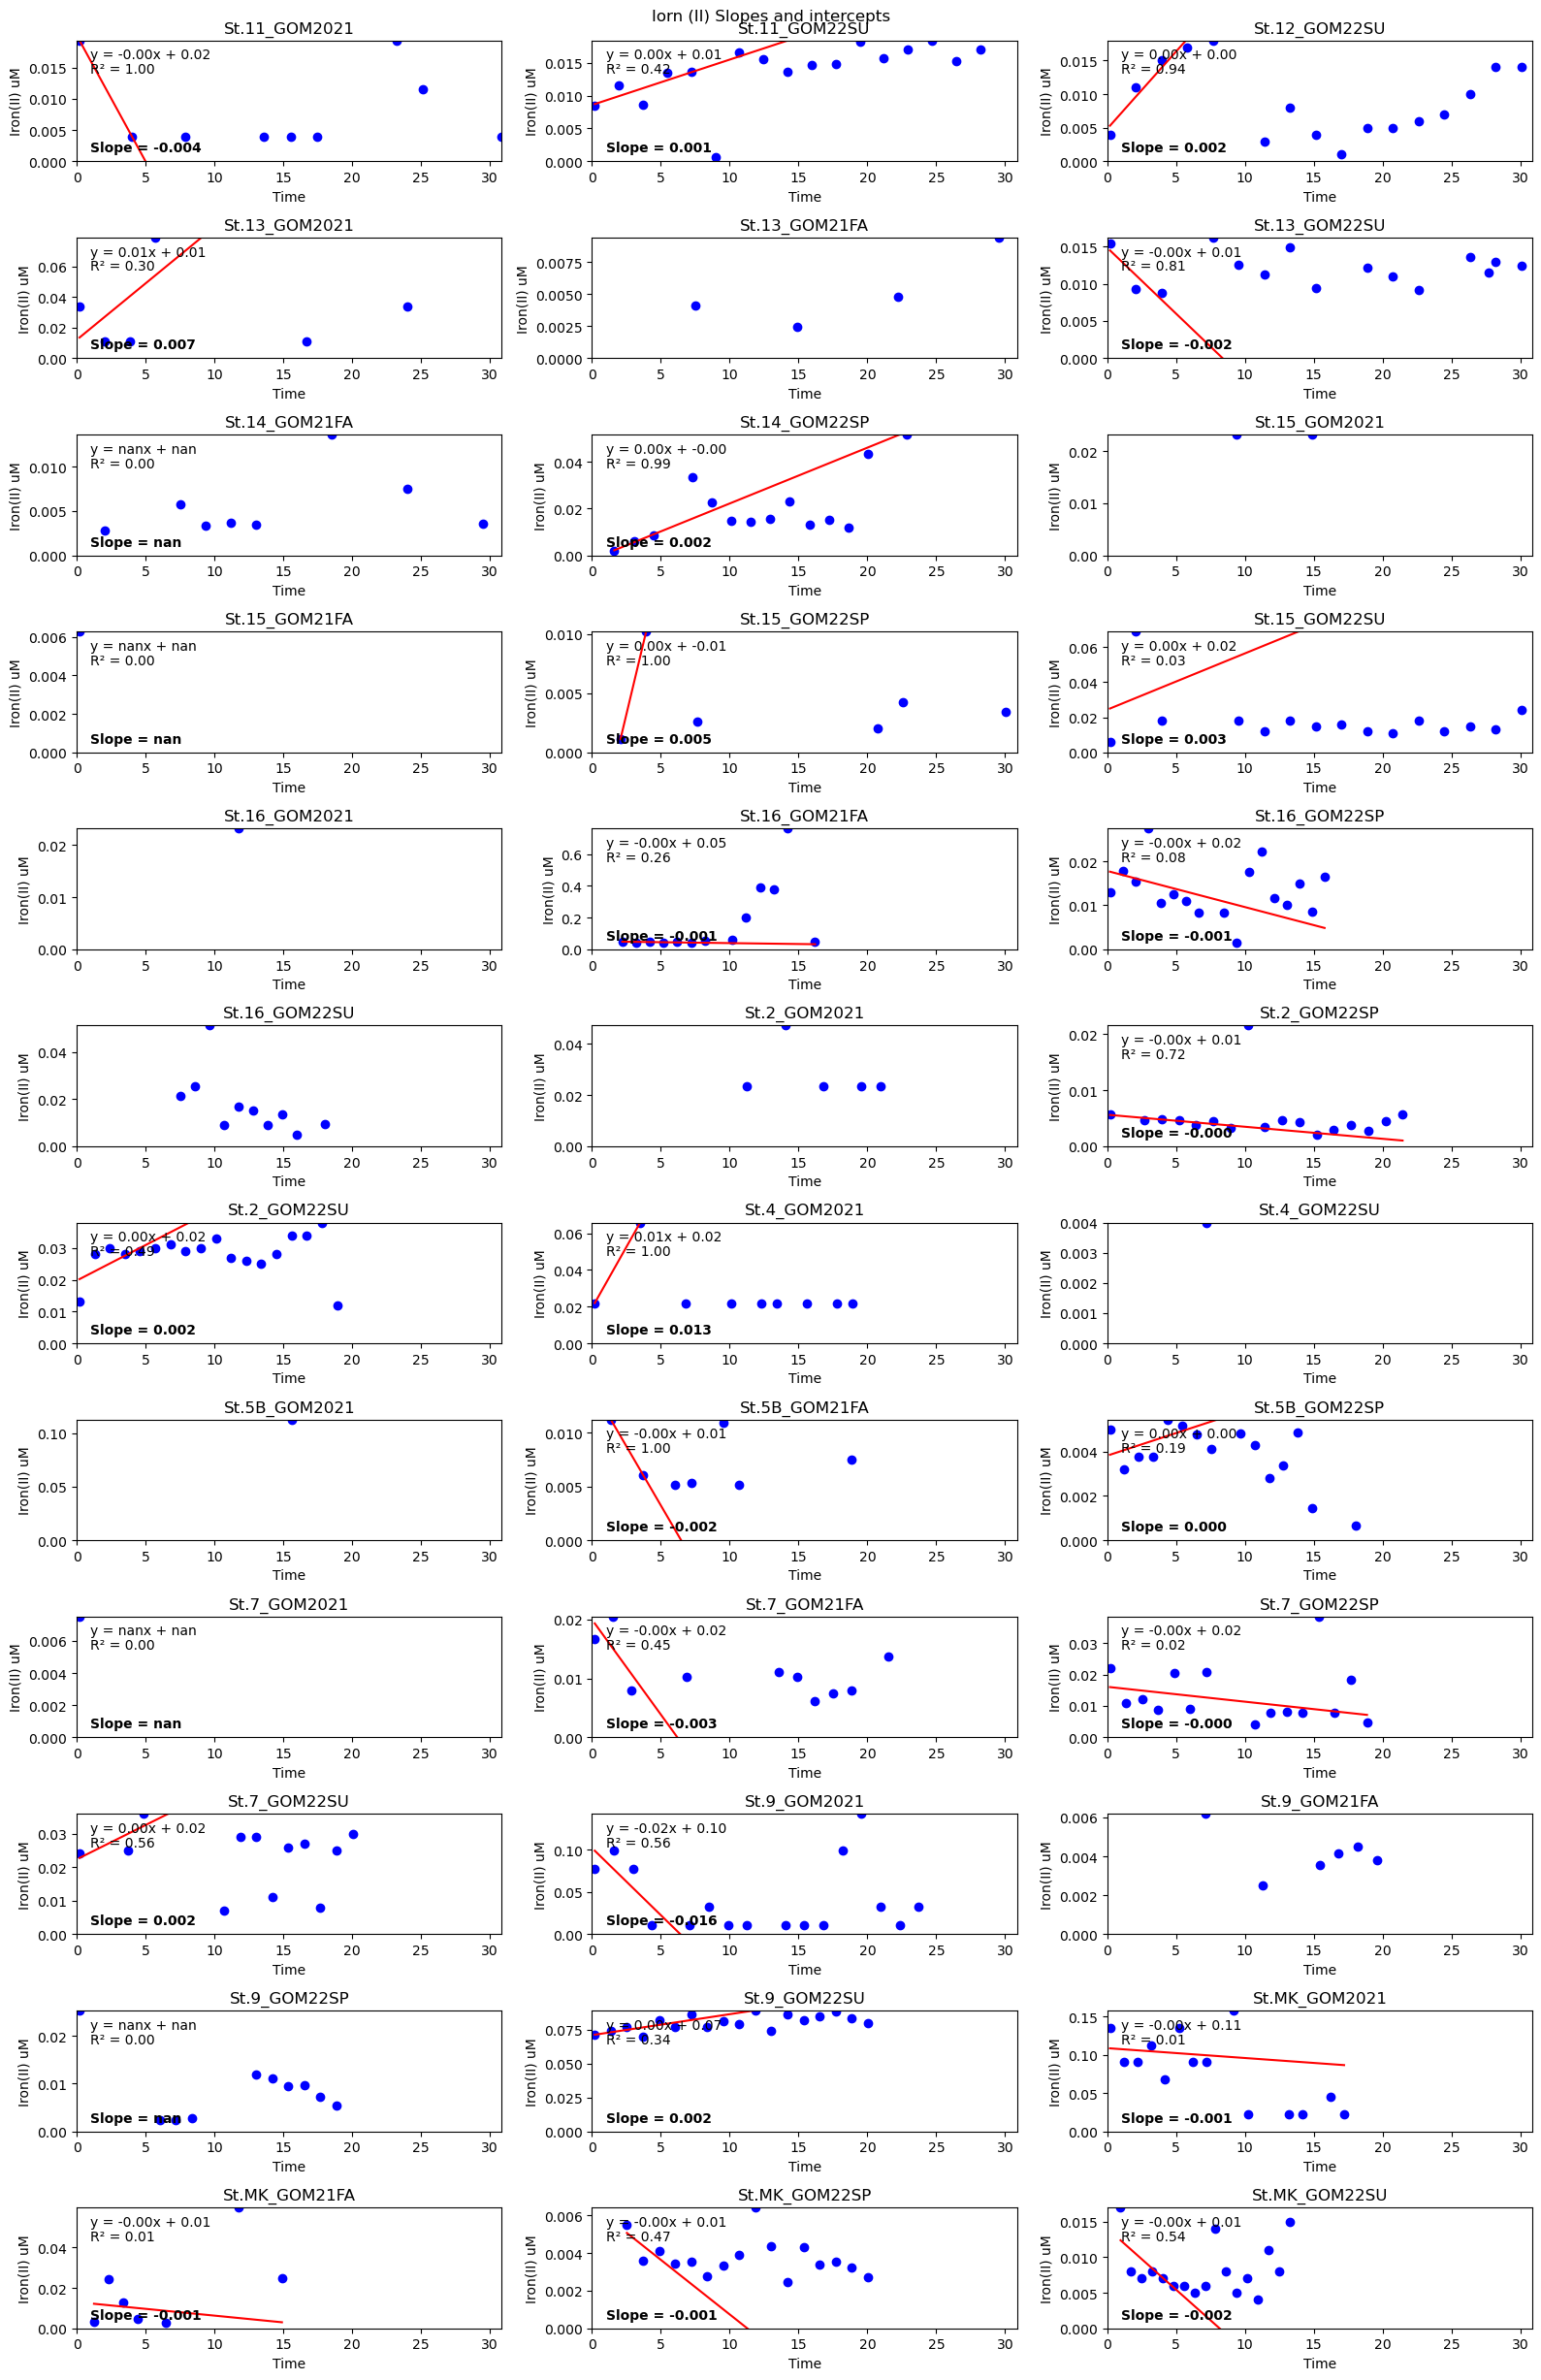

In [17]:
#Iron 2 slopes 

fig, axs = plt.subplots(nrows=12, ncols=3, figsize=(16, 25)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_iron_bc_fe2_cl.groupby('code')):
    # Extract x, y, and c data from the group
    x = group['Fe2_Time']
    y = group['Fe2_uM']
    
    xx = group.loc[group['Fe2_Time'] <6 , 'Fe2_Time'].ravel()
    yy = group.loc[group['Fe2_Time'] <6, 'Fe2_uM'].ravel()
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c='b')
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel('Iron(II) uM')
    ax.set_xlim(0,df_iron_bc_fe2_cl['Fe2_Time'].max())
    ax.set_ylim(0,max(y))
    
    if len(xx) > 0 and len(yy) > 0:
        # Calculate the slope of the regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        
        # Add the regression line to the plot
        ax.plot(x, intercept + slope * x, c='r')
    
        # Add the equation of the regression line to the plot
        equation = f'y = {slope:.2f}x + {intercept:.2f}'
        ax.text(1, max(y)*.85, equation)
    
        # Add the r-squared value to the plot
        rsquared = f'R² = {r_value**2:.2f}'
        ax.text(1, max(y)*.73, rsquared)
    
        # Add the slope value to the plot
        sloped = f'Slope = {slope:.3f}'
        ax.text(1, max(y)*.08, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'Iorn (II) Slopes and intercepts' '\n')
plt.tight_layout()
plt.show()


In [18]:
#Fe2 slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_iron_bc_fe2_cl.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group.loc[group['Fe2_Time'] <6 , 'Fe2_Time'].ravel()
    y = group.loc[group['Fe2_Time'] <6, 'Fe2_uM'].ravel()

    if len(x) > 0 and len(y) > 0:
        # Calculate the slope of the regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

        # Add the r-squared value to the plot
        rsquared = r_value**2
    
        # Add the slope value to the plot
        slope = slope
    
        dic = {'code':[code],
               'slope_fe2':[slope],
               'rsquared_fe2':[rsquared]}
    
        slopes = pd.DataFrame(dic)
        slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_fe2 = pd.concat(Frames, axis=0, ignore_index=False)
slopes_fe2

C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\hmlbr\anaconda3\envs\b

,slope_fe2,rsquared_fe2
code,,
St.11_GOM2021,-0.004036,1.000000
St.11_GOM22SU,0.000691,0.415760
St.12_GOM22SU,0.002304,0.936203
St.13_GOM2021,0.007384,0.300000
St.13_GOM2021,0.007384,0.300000
St.13_GOM22SU,-0.001768,0.806468
St.14_GOM21FA,NaN,0.000000
St.14_GOM22SP,0.002387,0.989305
St.14_GOM22SP,0.002387,0.989305


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


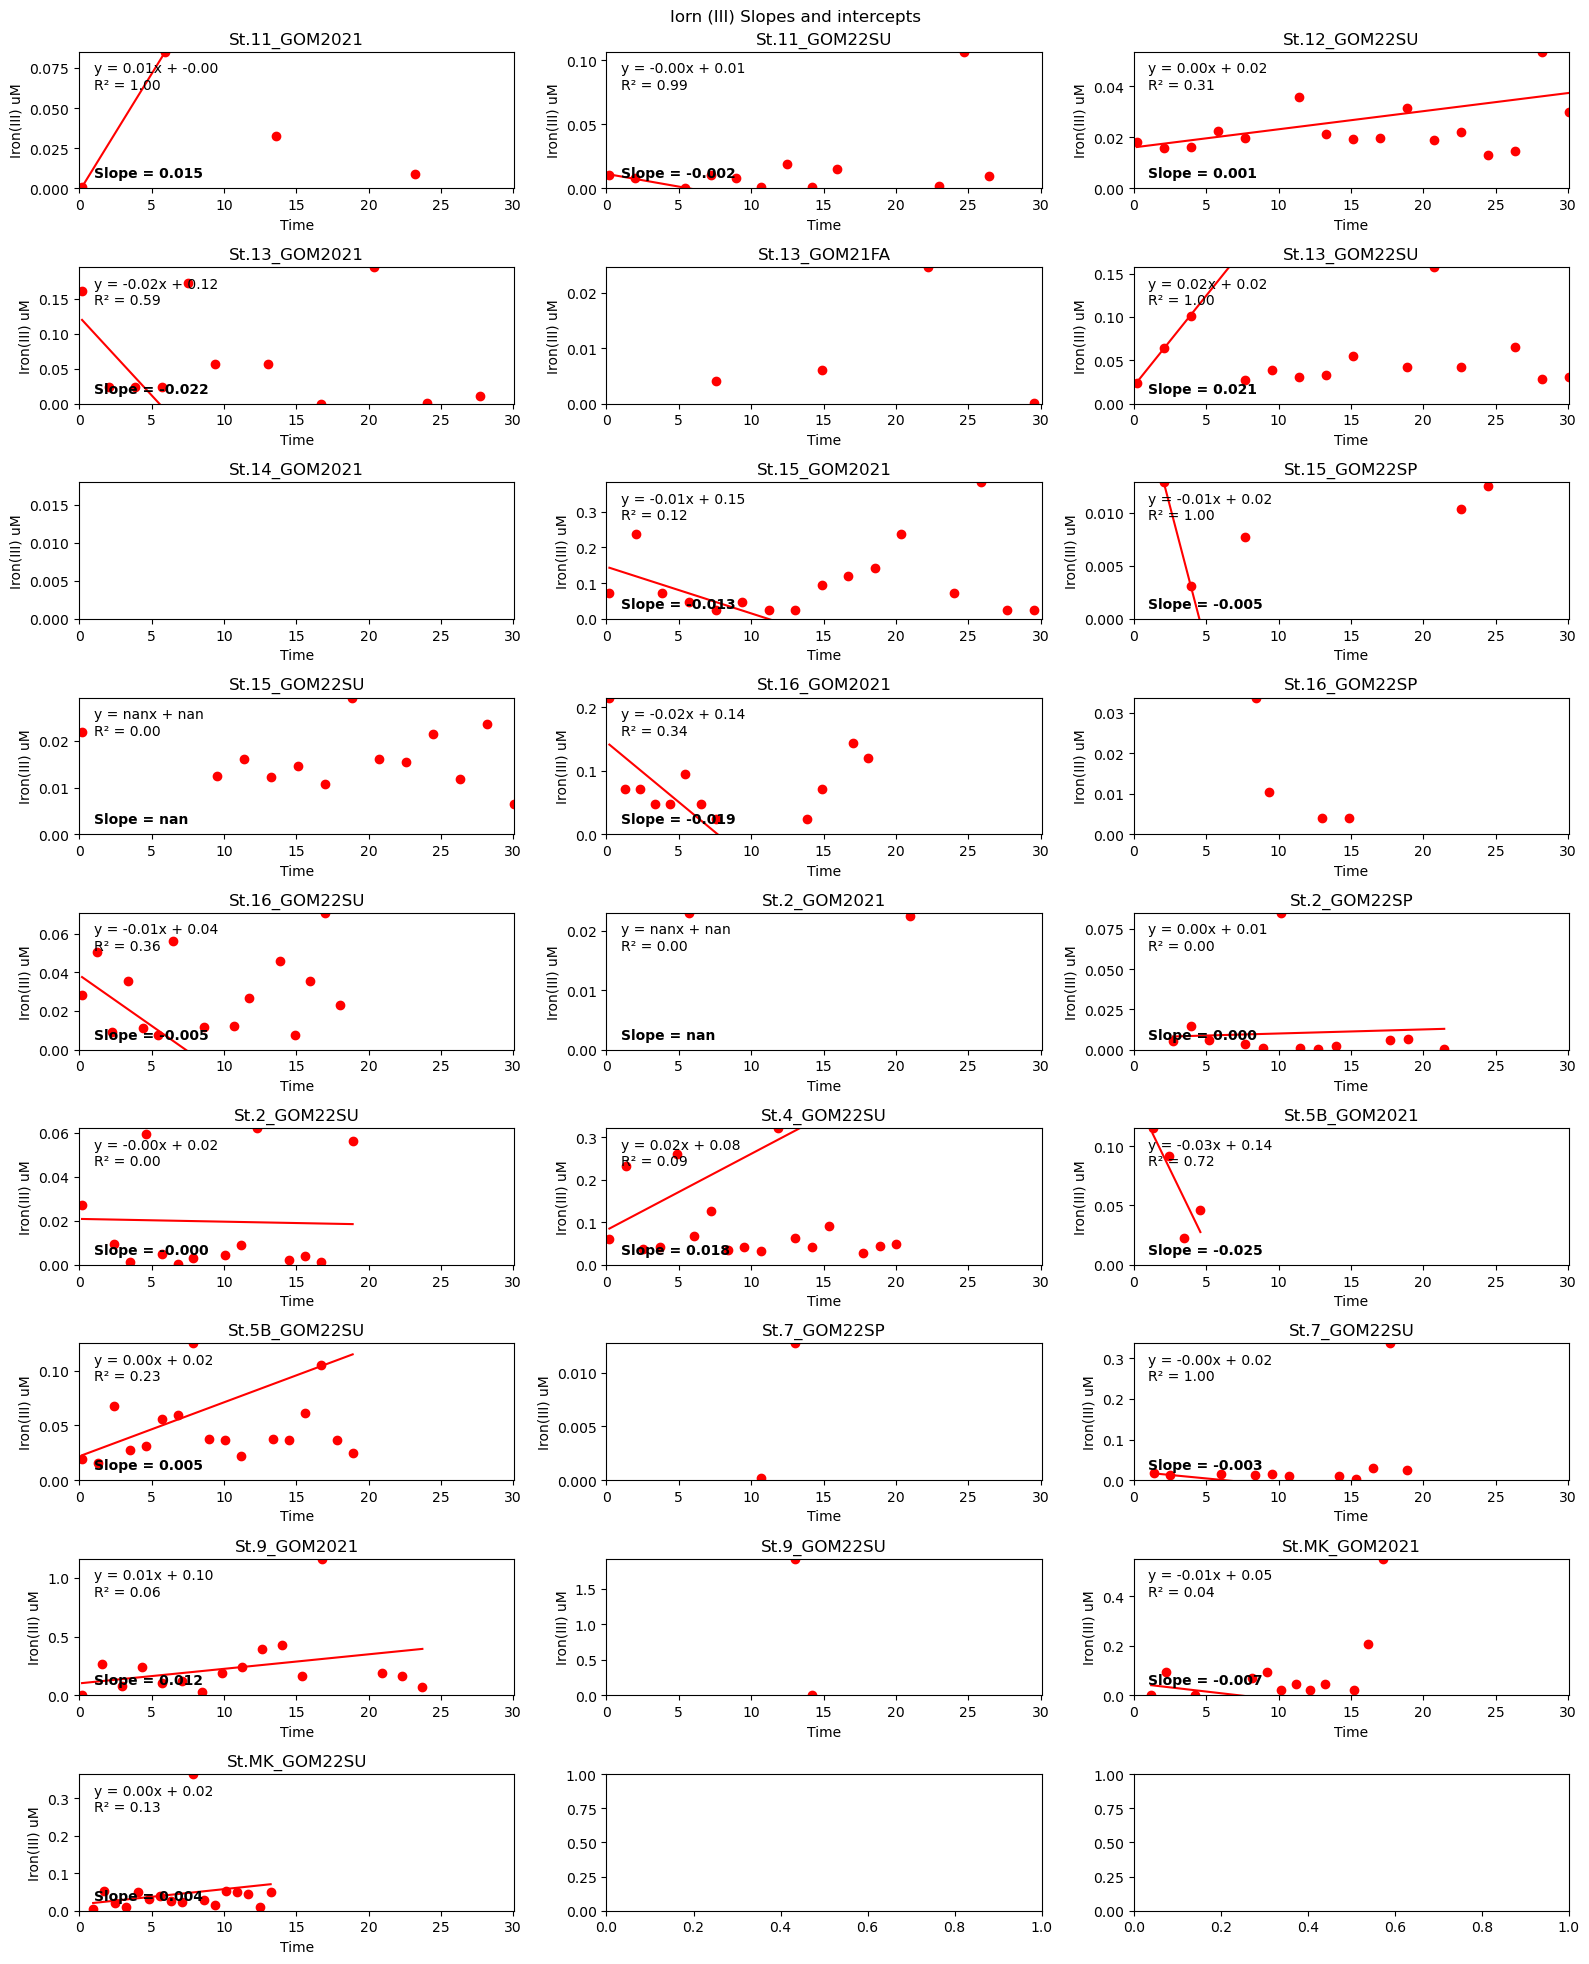

In [19]:
#Iron 3 slopes 

fig, axs = plt.subplots(nrows=9, ncols=3, figsize=(16, 20)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_iron_bc_fe3_cl.groupby('code')):
    # Extract x, y, and c data from the group
    x = group['FeT_Time'].ravel()
    y = group['Fe3_uM'].ravel()
    
    xx = group.loc[group['FeT_Time'] <6 , 'FeT_Time'].ravel()
    yy = group.loc[group['FeT_Time'] <6, 'Fe3_uM'].ravel()
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c='r')
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel('Iron(III) uM')
    ax.set_xlim(0,df_iron_bc_fe3_cl['FeT_Time'].max())
    ax.set_ylim(0,max(y))
    
    if len(xx) > 0 and len(yy) > 0:
        # Calculate the slope of the regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)

    # Add the regression line to the plot
        ax.plot(x, intercept + slope * x, c='r')
    
    # Add the equation of the regression line to the plot
        equation = f'y = {slope:.2f}x + {intercept:.2f}'
        ax.text(1, max(y)*.85, equation)
    
    # Add the r-squared value to the plot
        rsquared = f'R² = {r_value**2:.2f}'
        ax.text(1, max(y)*.73, rsquared)
    
    # Add the slope value to the plot
        sloped = f'Slope = {slope:.3f}'
        ax.text(1, max(y)*.08, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'Iorn (III) Slopes and intercepts' '\n')
plt.tight_layout()
plt.show()

In [20]:
#Fe3 slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_iron_bc_fe3_cl.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group.loc[group['FeT_Time'] <6 , 'FeT_Time'].ravel()
    y = group.loc[group['FeT_Time'] <6, 'Fe3_uM'].ravel()    
    
    
    if len(x) > 0 and len(y) > 0:
        # Calculate the slope of the regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the r-squared value to the plot
        rsquared = r_value**2
    
    # Add the slope value to the plot
        slope = slope
    
        dic = {'code':[code],
               'slope_fe3':[slope],
               'rsquared_fe3':[rsquared]}
        
        slopes = pd.DataFrame(dic)
        slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_fe3 = pd.concat(Frames, axis=0, ignore_index=False)
slopes_fe3

C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\hmlbr\anaconda3\envs\b

,slope_fe3,rsquared_fe3
code,,
St.11_GOM2021,0.014638,1.000000
St.11_GOM22SU,-0.001984,0.988698
St.12_GOM22SU,0.000708,0.308314
St.13_GOM2021,-0.022441,0.592285
St.13_GOM2021,-0.022441,0.592285
St.13_GOM22SU,0.020826,0.999175
St.13_GOM22SU,0.020826,0.999175
St.15_GOM2021,-0.013023,0.121952
St.15_GOM22SP,-0.005221,1.000000


In [21]:
#make location data 
df_lat_lon = df_meta.groupby('code').agg({'Lat': 'mean', 'Lon': 'mean'}).reset_index().set_index('code')

In [22]:
dataframes = [df_hights, df_lat_lon, slopes_a350, slopes_doc, slopes_tn]
for df in dataframes:
    if not df.index.is_unique:
        print("Duplicate indices found in dataframe:", df)


In [23]:
#concat it all 
df_flux = pd.concat([df_hights, df_lat_lon, slopes_a350, 
                     slopes_doc, slopes_tn], axis=1, join='outer')

#calcute flux 
#df_flux["flux_aCDOM412"] = df_flux["slope_a412"] * (df_flux["Hight_m"]*(np.pi*((30/100)**2))) / (np.pi*((30/100)**2)) * 24 
df_flux["flux_aCDOM350"] = (df_flux["slope_a350"] * (df_flux["Hight_m"]*(np.pi*((30/100)**2))) / (np.pi*((30/100)**2)) * 24) / x_equal 
df_flux["flux_doc"] = df_flux["slope_doc"] * (((df_flux["Hight_m"]*(np.pi*((30/100)**2)))*1000) / (np.pi*((30/100)**2))) * 24 /1000

df_flux["erros_aCDOM350"] = (df_flux["std_err_a350"] * (df_flux["Hight_m"]*(np.pi*((30/100)**2))) / (np.pi*((30/100)**2)) * 24) / x_equal 
df_flux["erros_doc"] = df_flux["std_err_doc"] * (((df_flux["Hight_m"]*(np.pi*((30/100)**2)))*1000) / (np.pi*((30/100)**2))) * 24 /1000



#df_flux["flux_tn"] = df_flux["slope_tn"] * ((df_flux["Hight_m"]*(np.pi*((30/100)**2)))*1000) / (np.pi*((30/100)**2)) * 24 / 1000 
#df_flux["flux_fe2"] = df_flux["slope_fe2"] * df_flux["Hight_m"] *24
#df_flux["flux_fe3"] = df_flux["slope_fe3"] * df_flux["Hight_m"] *24

df_flux

,Camp,Stn,Hight_m,Lat,Lon,slope_a350,rsquared_a350,std_err_a350,note_a350,slope_doc,...,std_err_doc,note_doc,slope_tn,rsquared_tn,std_err_tn,note_tn,flux_aCDOM350,flux_doc,erros_aCDOM350,erros_doc
code,,,,,,,,,,,,,,,,,,,,,
St.4_GOM22SU,GOM22SU,St.4,0.042412,28.793151,-90.697399,0.001249,0.004503,0.003961,8 hours,2.671875,...,4.094270,10 hours,0.276212,0.537624,0.096817,10 hours,0.005943,2.719638,0.018840,4.167460
St.5B_GOM22SU,GOM22SU,St.5B,0.045239,28.797889,-91.322172,0.047642,0.702268,0.009810,4 hours,-12.860953,...,16.853291,10 hours,0.021820,0.000102,0.815191,10 hours,0.241721,-13.963580,0.049771,18.298198
St.7_GOM22SU,GOM22SU,St.7,0.040527,28.909318,-89.856156,-0.006235,0.228135,0.002445,10 hours,-0.286505,...,3.896469,10 hours,-0.337004,0.256421,0.234286,10 hours,-0.028340,-0.278666,0.011114,3.789850
St.9_GOM22SU,GOM22SU,St.9,0.030536,28.786307,-89.598689,-0.017646,0.199593,0.007067,10 hours,1.235923,...,3.902038,10 hours,0.252976,0.385333,0.130438,10 hours,-0.060433,0.905772,0.024204,2.859689
St.14_GOM22SU,GOM22SU,St.14,0.032987,28.728776,-89.620647,0.038765,0.999380,0.000483,4 hours,-12.158167,...,7.303104,10 hours,-0.849055,0.484177,0.438181,10 hours,0.143413,-9.625394,0.001787,5.781731
St.15_GOM22SU,GOM22SU,St.15,0.034118,28.950645,-88.842176,-0.004455,0.278883,0.002265,10 hours,7.188008,...,1.649380,6 hours,0.625699,0.992283,0.055178,6 hours,-0.017047,5.885719,0.008669,1.350553
St.13_GOM22SU,GOM22SU,St.13,0.030159,28.524547,-89.597871,-0.001986,0.091764,0.001562,10 hours,18.939732,...,0.805455,4 hours,0.608546,0.237825,0.544706,10 hours,-0.006717,13.709013,0.005283,0.583007
St.2_GOM22SU,GOM22SU,St.2,0.027921,28.896161,-89.585844,0.009355,0.466066,0.003166,4 hours,5.486442,...,2.452697,10 hours,1.468891,0.795252,0.304279,10 hours,0.029294,3.676474,0.009915,1.643556
St.16_GOM22SU,GOM22SU,St.16,0.028746,28.891260,-89.536424,0.000252,0.004498,0.000800,8 hours,4.918928,...,2.153745,10 hours,0.342417,0.766994,0.071333,10 hours,0.000813,3.393538,0.002578,1.485855


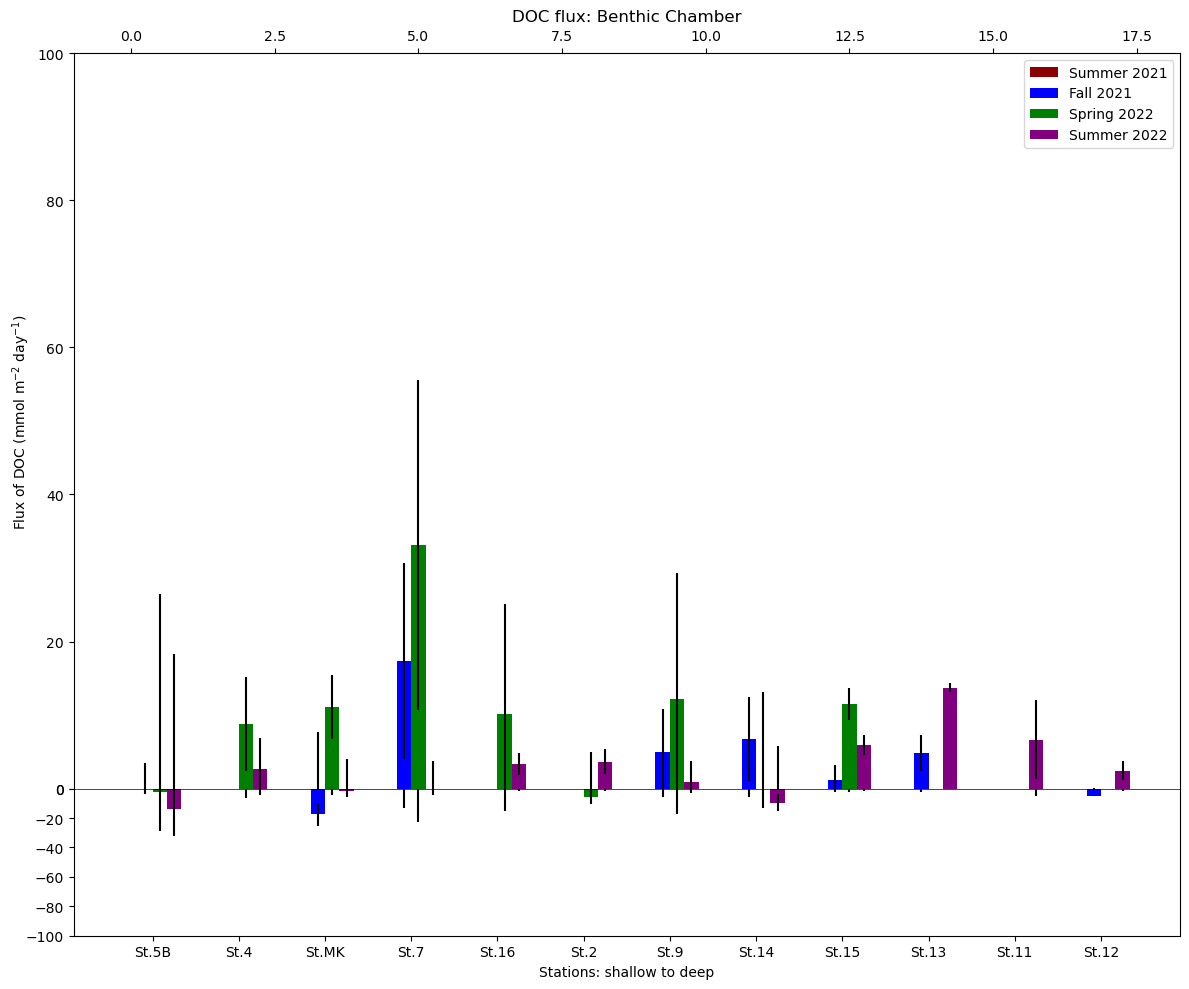

In [24]:
# Unique categories and subcategories
df = df_flux.dropna(subset=["flux_doc"])

categories = ['St.5B','St.4','St.MK','St.7','St.16','St.2','St.9','St.14','St.15','St.13','St.11','St.12']
subcategories = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Define custom colors
color_map = {
    'GOM2021': 'darkred',
    'GOM21FA': 'blue',
    'GOM22SP': 'green',
    'GOM22SU': 'purple'
}

# Define custom labels (if they differ from subcategory names)
label_map = {
    'GOM2021': 'Summer 2021',
    'GOM21FA': 'Fall 2021',
    'GOM22SP': 'Spring 2022',
    'GOM22SU': 'Summer 2022'
}

barWidth = 0.25

# Create figure with custom size
fig = plt.figure(figsize=(12, 10))
# Adjust the height ratios for the subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0)  # Set hspace to 0

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# Adjusted r for spacing between groups
r = np.arange(0, len(categories) * 1.5, 1.5)
positions = [r + i*barWidth for i in range(len(subcategories))]

# Adjusted code for broken axis and added spaces between the groups
for pos, subcat in zip(positions, subcategories):
    values = []
    errors = []
    for cat in categories:
        value = df[(df['Stn'] == cat) & (df['Camp'] == subcat)]['flux_doc'].values
        error = df[(df['Stn'] == cat) & (df['Camp'] == subcat)]['erros_doc'].values
        values.append(value[0] if len(value) > 0 else 0)
        errors.append(error[0] if len(error) > 0 else 0)
    
    ax1.bar(pos, [v if v > 0 else 0 for v in values], width=barWidth, color=color_map[subcat],
            label=label_map[subcat], yerr=[e if e > 0 else 0 for e in errors])
    ax2.bar(pos, [v if v < 0 else 0 for v in values], width=barWidth, color=color_map[subcat],
            label=label_map[subcat], yerr=[e if e > 0 else 0 for e in errors])
    
# Setting the limit for the break
ax1.set_ylim(0, 100)  
ax2.set_ylim(-100, 0)

# Removing spines and ticks for the broken axis effect
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

# Add some text for labels, title, and custom x-axis tick labels
ax2.set_xlabel('Stations: shallow to deep')
ax1.set_ylabel(r'Flux of DOC (mmol m$^{-2}$ day$^{-1}$)')
ax1.set_title('DOC flux: Benthic Chamber')
ax2.set_xticks(r + 1.5*barWidth)  # Adjust for the spaces between groups
ax2.set_xticklabels(categories)

# Add black horizontal line at y=0
ax1.axhline(0, color="black", linewidth=0.5)
ax2.axhline(0, color="black", linewidth=0.5)

handles, _ = plt.gca().get_legend_handles_labels()
labels = [label_map[subcat] for subcat in subcategories]
ax1.legend(handles[:len(subcategories)], labels)

fig.set_facecolor('w')
plt.tight_layout()

plt.savefig("../Dissertation_projects/Figures/Flux_figures/DOC_flux_barplot.png")
plt.show()


# Unique categories and subcategories
df = df_flux.dropna(subset=["flux_aCDOM412"])

categories = ['St.5B','St.4','St.MK','St.7','St.16','St.2','St.9','St.14','St.15','St.13','St.11','St.12']
subcategories = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Define custom colors
color_map = {
    'GOM2021': 'darkred',
    'GOM21FA': 'blue',
    'GOM22SP': 'green',
    'GOM22SU': 'purple'
}

# Define custom labels (if they differ from subcategory names)
label_map = {
    'GOM2021': 'Summer 2021',
    'GOM21FA': 'Fall 2021',
    'GOM22SP': 'Spring 2022',
    'GOM22SU': 'Summer 2022'
}

barWidth = 0.25

fig, axs = plt.subplots(figsize=(10, 8)) 

# Set position of bars on x axis
r = np.arange(len(categories))
positions = [r + i*barWidth for i in range(len(subcategories))]

all_bars = []

for pos, subcat in zip(positions, subcategories):
    values = []
    for cat in categories:
        value = df[(df['Stn'] == cat) & (df['Camp'] == subcat)]['flux_aCDOM412'].values
        values.append(value[0] if len(value) > 0 else 0)
    bars = plt.bar(pos, values, width=barWidth, color=color_map[subcat], label=label_map[subcat])
    all_bars.append(bars)
    
plt.legend()

handles, _ = plt.gca().get_legend_handles_labels()
labels = [label_map[subcat] for subcat in subcategories]
plt.legend(handles[:len(subcategories)], labels)

# Add some text for labels, title, and custom x-axis tick labels
plt.xlabel('Stations: shallow to deep')
plt.ylabel(r'Flux of CDOM: $a_{\mathrm{CDOM}}$ 412 (nm) $(m^{-1})$ (m$^{-2}$ day$^{-1}$)')
plt.title('CDOM 412 flux: Benthic Chamber')
plt.xticks(r + barWidth, categories)
plt.ylim(-.1,.6)


plt.legend()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/CDOM412_flux_barplot.png")

plt.show()

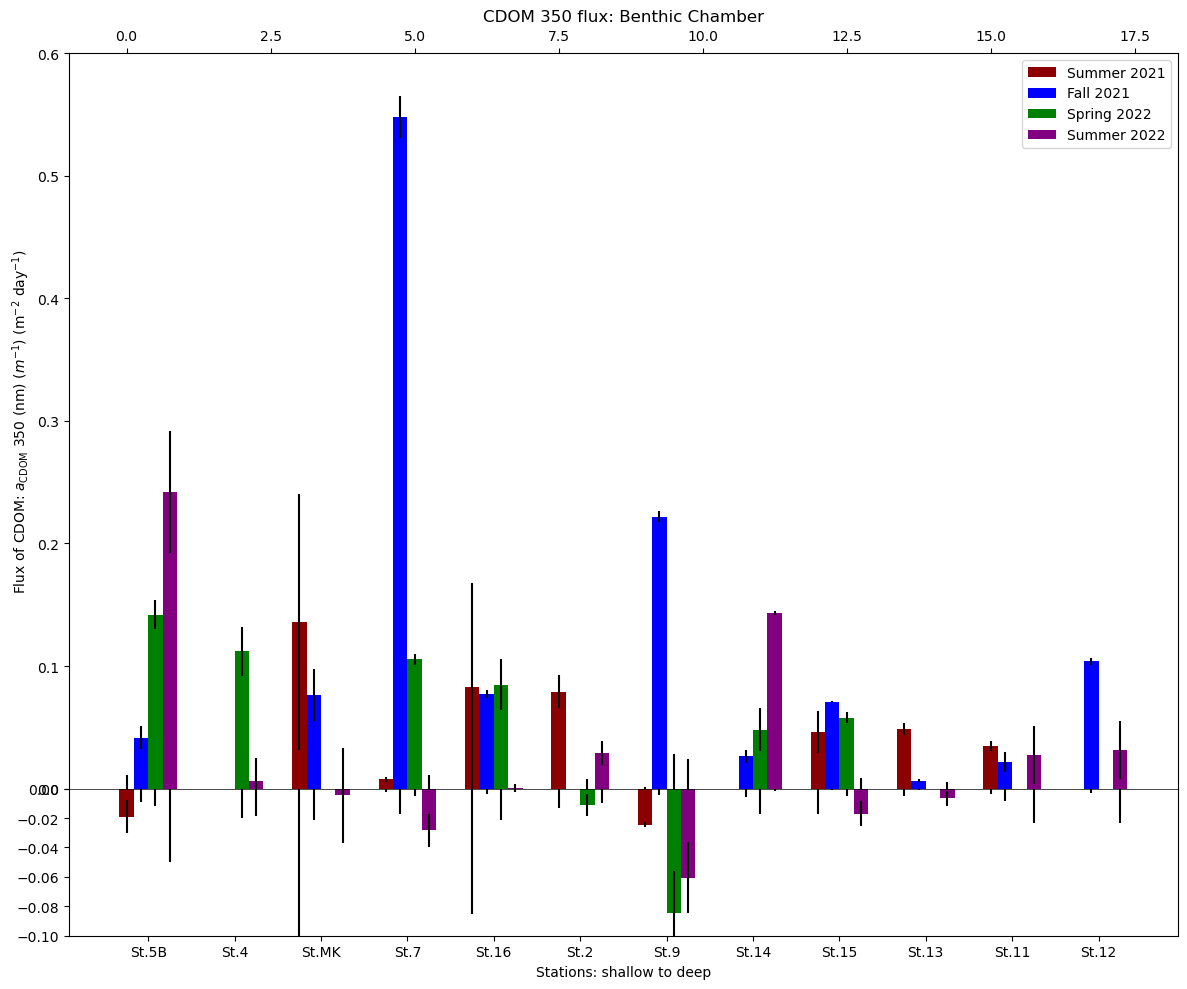

In [25]:
# Unique categories and subcategories
df = df_flux.dropna(subset=["flux_aCDOM350"])

categories = ['St.5B','St.4','St.MK','St.7','St.16','St.2','St.9','St.14','St.15','St.13','St.11','St.12']
subcategories = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Define custom colors
color_map = {
    'GOM2021': 'darkred',
    'GOM21FA': 'blue',
    'GOM22SP': 'green',
    'GOM22SU': 'purple'
}

# Define custom labels (if they differ from subcategory names)
label_map = {
    'GOM2021': 'Summer 2021',
    'GOM21FA': 'Fall 2021',
    'GOM22SP': 'Spring 2022',
    'GOM22SU': 'Summer 2022'
}

barWidth = 0.25

# Create figure with custom size
fig = plt.figure(figsize=(12, 10))
# Adjust the height ratios for the subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0)  # Set hspace to 0

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# Adjusted r for spacing between groups
r = np.arange(0, len(categories) * 1.5, 1.5)
positions = [r + i*barWidth for i in range(len(subcategories))]

# Adjusted code for broken axis and added spaces between the groups
for pos, subcat in zip(positions, subcategories):
    values = []
    errors = []
    for cat in categories:
        value = df[(df['Stn'] == cat) & (df['Camp'] == subcat)]['flux_aCDOM350'].values
        error = df[(df['Stn'] == cat) & (df['Camp'] == subcat)]['erros_aCDOM350'].values
        values.append(value[0] if len(value) > 0 else 0)
        errors.append(error[0] if len(error) > 0 else 0)
    
    ax1.bar(pos, [v if v > 0 else 0 for v in values], width=barWidth, color=color_map[subcat],
            label=label_map[subcat], yerr=[e if e > 0 else 0 for e in errors])
    ax2.bar(pos, [v if v < 0 else 0 for v in values], width=barWidth, color=color_map[subcat],
            label=label_map[subcat], yerr=[e if e > 0 else 0 for e in errors])

# Setting the limit for the break
ax1.set_ylim(0, .6)  
ax2.set_ylim(-.1, 0)

# Removing spines and ticks for the broken axis effect
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

# Add some text for labels, title, and custom x-axis tick labels
ax2.set_xlabel('Stations: shallow to deep')
ax1.set_ylabel(r'Flux of CDOM: $a_{\mathrm{CDOM}}$ 350 (nm) $(m^{-1})$ (m$^{-2}$ day$^{-1}$)')
ax1.set_title('CDOM 350 flux: Benthic Chamber')
ax2.set_xticks(r + 1.5*barWidth)  # Adjust for the spaces between groups
ax2.set_xticklabels(categories)

# Add black horizontal line at y=0
ax1.axhline(0, color="black", linewidth=0.5)
ax2.axhline(0, color="black", linewidth=0.5)

handles, _ = plt.gca().get_legend_handles_labels()
labels = [label_map[subcat] for subcat in subcategories]
ax1.legend(handles[:len(subcategories)], labels)

fig.set_facecolor('w')
plt.tight_layout()

plt.savefig("../Dissertation_projects/Figures/Flux_figures/CDOM350_flux_barplot.png")
plt.show()


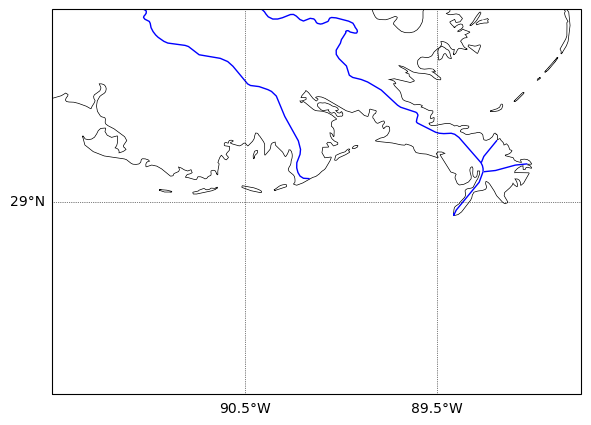

In [26]:
lat_top=30
lat_bot=28
lon_left=-91.5
lon_rigth=-88.75
extent=[lon_left, lon_rigth, lat_bot, lat_top]

# set resolution of the features in map: '10m', '50m', or '110m'.  
# If you do this the first time it will take a while downloading the coastline 
# and other features. In the future it will be faster
res = '10m'

#Figure


def plot_mapbase(extent, res='10m', projection=ccrs.PlateCarree()):
    fig = plt.figure(figsize=(10,5)) # set fig size
    ax = fig.add_subplot(111, projection=projection)
    ax.set_extent(extent)
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='white', # change color here
                                                scale=res)) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue', # change color here
                                                facecolor='none',
                                                scale=res))
    gl = ax.gridlines(xlocs=np.arange(lon_left, lon_rigth+1),
                      ylocs=np.arange(lat_bot, lat_top+1),
                      draw_labels=True, 
                      linewidth=0.5, color='k', linestyle=':')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

fig, ax = plot_mapbase(extent)


In [27]:
def plot_mapbase(extent, ax=None, res='10m', projection=ccrs.PlateCarree()):
    if ax is None:
        fig = plt.figure(figsize=(10,5)) # set fig size
        ax = fig.add_subplot(111, projection=projection)
        
    ax.set_extent(extent)
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='white', 
                                                scale=res)) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue',
                                                facecolor='none',
                                                scale=res))
    gl = ax.gridlines(xlocs=np.arange(lon_left, lon_rigth+1),
                      ylocs=np.arange(lat_bot, lat_top+1),
                      draw_labels=True, 
                      linewidth=0.5, color='k', linestyle=':')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax


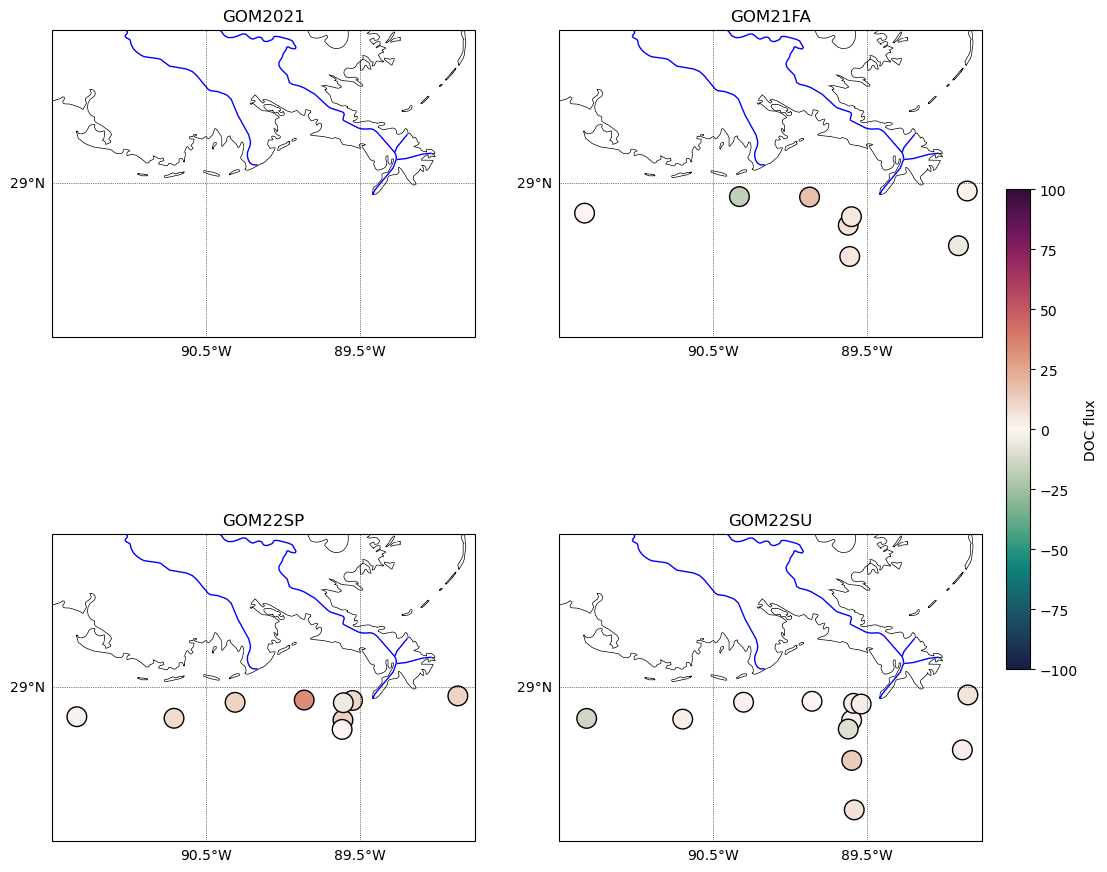

In [28]:
# List of unique Camp values you want to plot
camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Find global min and max for the colormap
vmin = -100
vmax = 100

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index

for i, camp in enumerate(camps):
    df_subset = df_flux[df_flux['Camp'] == camp].dropna(subset=["flux_doc"])    
    
    # Plot the base map for each subplot
    plot_mapbase(extent, ax=axes[i])
    
    # Plotting
    mappable = axes[i].scatter(df_subset['Lon'], df_subset['Lat'],
                               c=df_subset['flux_doc'],
                               edgecolor='k',
                               cmap=cmo.curl,
                               s=200,
                               vmin=vmin,  # Set global min and max for colormap
                               vmax=vmax,
                               transform=ccrs.PlateCarree())
    
    # Set title for each subplot
    axes[i].set_title(camp)
    
# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cb = fig.colorbar(mappable, cax=cbar_ax)
cb.set_label('DOC flux', size=10, color='black')
cb.ax.tick_params(labelcolor='black') 
cb.ax.tick_params(labelsize=10)

#plt.title(r'DOC flux:'+'\n'+' Benthic Chamber'+'\n')

fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/Map_DOC_Flux.png")

plt.show()


# List of unique Camp values you want to plot
camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Find global min and max for the colormap
vmin = -.6
vmax = .6

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index

for i, camp in enumerate(camps):
    df_subset = df_flux[df_flux['Camp'] == camp].dropna(subset=["flux_aCDOM412"])
    
    # Plot the base map for each subplot
    plot_mapbase(extent, ax=axes[i])
    
    # Plotting
    mappable = axes[i].scatter(df_subset['Lon'], df_subset['Lat'],
                               c=df_subset['flux_aCDOM412'],
                               edgecolor='k',
                               cmap=cmo.diff,
                               s=200,
                               vmin=vmin,  # Set global min and max for colormap
                               vmax=vmax,
                               transform=ccrs.PlateCarree())
    
    # Set title for each subplot
    axes[i].set_title(camp)
    
# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cb = fig.colorbar(mappable, cax=cbar_ax)
cb.set_label('a412 flux', size=10, color='black')
cb.ax.tick_params(labelcolor='black') 
cb.ax.tick_params(labelsize=10)

plt.title(r'CDOM 412 flux:'+'\n'+' Benthic Chamber'+'\n')

fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/Map_CDOM412_Flux.png")

plt.show()


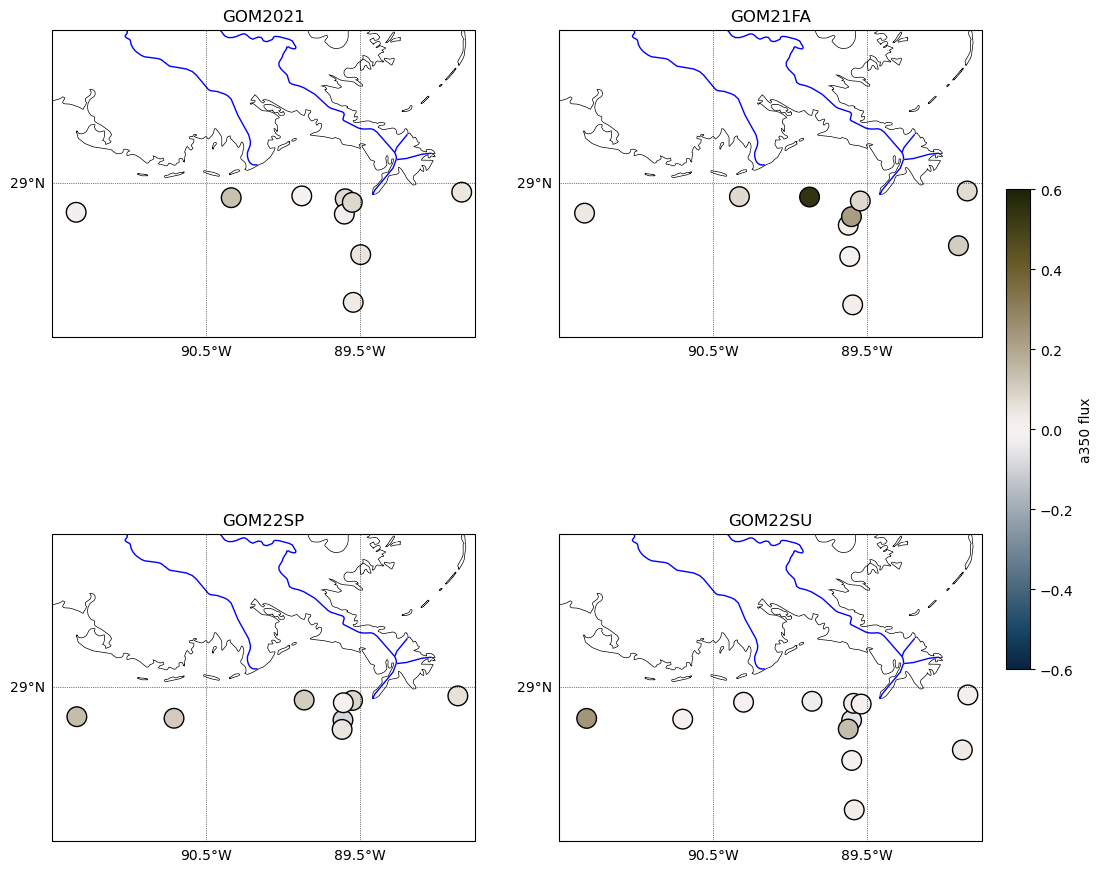

In [29]:
# List of unique Camp values you want to plot
camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Find global min and max for the colormap
vmin = -.6
vmax = .6

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index

for i, camp in enumerate(camps):
    df_subset = df_flux[df_flux['Camp'] == camp].dropna(subset=["flux_aCDOM350"])
    
    # Plot the base map for each subplot
    plot_mapbase(extent, ax=axes[i])
    
    # Plotting
    mappable = axes[i].scatter(df_subset['Lon'], df_subset['Lat'],
                               c=df_subset['flux_aCDOM350'],
                               edgecolor='k',
                               cmap=cmo.diff,
                               s=200,
                               vmin=vmin,  # Set global min and max for colormap
                               vmax=vmax,
                               transform=ccrs.PlateCarree())
    
    # Set title for each subplot
    axes[i].set_title(camp)
    
# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cb = fig.colorbar(mappable, cax=cbar_ax)
cb.set_label('a350 flux', size=10, color='black')
cb.ax.tick_params(labelcolor='black') 
cb.ax.tick_params(labelsize=10)

#plt.title(r'CDOM 350 flux:'+'\n'+' Benthic Chamber'+'\n')

fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/Map_CDOM350_Flux.png")

plt.show()


# Define the camps and flux types
camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']
flux_types = ['flux_aCDOM350', 'flux_doc']

# Create a 3x4 subplot grid
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})

for row, flux_type in enumerate(flux_types):
    # Determine the global min and max for the current flux type across all camps
    vmin = df_flux[df_flux['Camp'].isin(camps)][flux_type].min()
    vmax = df_flux[df_flux['Camp'].isin(camps)][flux_type].max()
    
    for col, camp in enumerate(camps):
        df_subset = df_flux[df_flux['Camp'] == camp].dropna(subset=[flux_type])
        
        mappable = axes[row, col].scatter(df_subset['Lon'], df_subset['Lat'],
                                          c=df_subset[flux_type],
                                          edgecolor='k',
                                          cmap=cmo.matter,
                                          s=100,
                                          vmin=vmin,
                                          vmax=vmax,
                                          transform=ccrs.PlateCarree())
        
        axes[row, col].set_title(f'{camp} - {flux_type}')
        
        plot_mapbase(extent, ax=axes[row, col])

    # Add a colorbar for each row (flux type)
    cbar_ax = fig.add_axes([0.92, 1-(0.29*(row+1)), 0.015, 0.125])
    cb = fig.colorbar(mappable, cax=cbar_ax)
    cb.set_label(flux_type, size=10, color='black')
    cb.ax.tick_params(labelcolor='black') 
    cb.ax.tick_params(labelsize=10)
    
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/Maps_Flux.png")

plt.show()
